In [1]:
ROOT_DATA_DIR = '../NICU_Data/DepthFrameFullPrec_prePT/'
ROOT_TRAIN_VAL_DATA_DIR = 'data/current/'
BASE_MODEL_NAME = 'vit_tiny_synthetic_prePT'
TRAIN_DIR = ROOT_TRAIN_VAL_DATA_DIR + 'train/'
VAL_DIR = ROOT_TRAIN_VAL_DATA_DIR + 'val/'
K_FOLDS = 5
BATCH_SIZE = 16
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
CLASS_WEIGHT = None
INITIAL_BIAS = None
LEARNING_RATE = 0.001
MOMENTUM = 0.9
FINETUNING = False

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from glob import glob
import shutil
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score
from tqdm import tqdm
import seaborn as sns
import timm

In [3]:
# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
noone_p1 = glob(ROOT_DATA_DIR + 'p1/noone/*.png')
nurse_p1 = glob(ROOT_DATA_DIR + 'p1/nurse/*.png')
noone_p2 = glob(ROOT_DATA_DIR + 'p2/noone/*.png')
nurse_p2 = glob(ROOT_DATA_DIR + 'p2/nurse/*.png')
noone_p5 = glob(ROOT_DATA_DIR + 'p5/noone/*.png')
nurse_p5 = glob(ROOT_DATA_DIR + 'p5/nurse/*.png')
noone_p6 = glob(ROOT_DATA_DIR + 'p6/noone/*.png')
nurse_p6 = glob(ROOT_DATA_DIR + 'p6/nurse/*.png')
noone_p8 = glob(ROOT_DATA_DIR + 'p8/noone/*.png')
nurse_p8 = glob(ROOT_DATA_DIR + 'p8/nurse/*.png')
noone_p9 = glob(ROOT_DATA_DIR + 'p9/noone/*.png')
nurse_p9 = glob(ROOT_DATA_DIR + 'p9/nurse/*.png')
noone_p10 = glob(ROOT_DATA_DIR + 'p10/noone/*.png')
nurse_p10 = glob(ROOT_DATA_DIR + 'p10/nurse/*.png')
noone_p11 = glob(ROOT_DATA_DIR + 'p11/noone/*.png')
nurse_p11 = glob(ROOT_DATA_DIR + 'p11/nurse/*.png')
noone_p13 = glob(ROOT_DATA_DIR + 'p13/noone/*.png')
nurse_p13 = glob(ROOT_DATA_DIR + 'p13/nurse/*.png')
noone_p14 = glob(ROOT_DATA_DIR + 'p14/noone/*.png')
nurse_p14 = glob(ROOT_DATA_DIR + 'p14/nurse/*.png')
noone_p15 = glob(ROOT_DATA_DIR + 'p15/noone/*.png')
nurse_p15 = glob(ROOT_DATA_DIR + 'p15/nurse/*.png')
noone_p16 = glob(ROOT_DATA_DIR + 'p16/noone/*.png')
nurse_p16 = glob(ROOT_DATA_DIR + 'p16/nurse/*.png')
noone_p17 = glob(ROOT_DATA_DIR + 'p17/noone/*.png')
nurse_p17 = glob(ROOT_DATA_DIR + 'p17/nurse/*.png')
noone_p21 = glob(ROOT_DATA_DIR + 'p21/noone/*.png')
nurse_p21 = glob(ROOT_DATA_DIR + 'p21/nurse/*.png')
noone_p22 = glob(ROOT_DATA_DIR + 'p22/noone/*.png')
nurse_p22 = glob(ROOT_DATA_DIR + 'p22/nurse/*.png')
noone_p23 = glob(ROOT_DATA_DIR + 'p23/noone/*.png')
nurse_p23 = glob(ROOT_DATA_DIR + 'p23/nurse/*.png')
noone_p24 = glob(ROOT_DATA_DIR + 'p24/noone/*.png')
nurse_p24 = glob(ROOT_DATA_DIR + 'p24/nurse/*.png')
noone_p25 = glob(ROOT_DATA_DIR + 'p25/noone/*.png')
nurse_p25 = glob(ROOT_DATA_DIR + 'p25/nurse/*.png')
noone_p26 = glob(ROOT_DATA_DIR + 'p26/noone/*.png')
nurse_p26 = glob(ROOT_DATA_DIR + 'p26/nurse/*.png')
noone_p27 = glob(ROOT_DATA_DIR + 'p27/noone/*.png')
nurse_p27 = glob(ROOT_DATA_DIR + 'p27/nurse/*.png')
noone_p28 = glob(ROOT_DATA_DIR + 'p28/noone/*.png')
nurse_p28 = glob(ROOT_DATA_DIR + 'p28/nurse/*.png')
noone_p29 = glob(ROOT_DATA_DIR + 'p29/noone/*.png')
nurse_p29 = glob(ROOT_DATA_DIR + 'p29/nurse/*.png')
noone_p30 = glob(ROOT_DATA_DIR + 'p30/noone/*.png')
nurse_p30 = glob(ROOT_DATA_DIR + 'p30/nurse/*.png')
noone_p31 = glob(ROOT_DATA_DIR + 'p31/noone/*.png')
nurse_p31 = glob(ROOT_DATA_DIR + 'p31/nurse/*.png')
noone_p32 = glob(ROOT_DATA_DIR + 'p32/noone/*.png')
nurse_p32 = glob(ROOT_DATA_DIR + 'p32/nurse/*.png')
noone_p33 = glob(ROOT_DATA_DIR + 'p33/noone/*.png')
nurse_p33 = glob(ROOT_DATA_DIR + 'p33/nurse/*.png')
noone_p34 = glob(ROOT_DATA_DIR + 'p34/noone/*.png')
nurse_p34 = glob(ROOT_DATA_DIR + 'p34/nurse/*.png')
nurse_p90 = glob(ROOT_DATA_DIR + 'p90/nurse/*.png')
nurse_p91 = glob(ROOT_DATA_DIR + 'p91/nurse/*.png')
nurse_p92 = glob(ROOT_DATA_DIR + 'p92/nurse/*.png')
nurse_p93 = glob(ROOT_DATA_DIR + 'p93/nurse/*.png')
nurse_p94 = glob(ROOT_DATA_DIR + 'p94/nurse/*.png')


all_noone_list = [noone_p1, noone_p2, noone_p5, noone_p6, noone_p8, noone_p9, noone_p10, noone_p11, noone_p13, noone_p14, noone_p15, noone_p16, noone_p17, noone_p21, noone_p22, noone_p23, noone_p24, noone_p25, noone_p26, noone_p27, noone_p28, noone_p29, noone_p30, noone_p31, noone_p32, noone_p33, noone_p34, [], [], [], [], []]
all_nurse_list = [nurse_p1, nurse_p2, nurse_p5, nurse_p6, nurse_p8, nurse_p9, nurse_p10, nurse_p11, nurse_p13, nurse_p14, nurse_p15, nurse_p16, nurse_p17, nurse_p21, nurse_p22, nurse_p23, nurse_p24, nurse_p25, nurse_p26, nurse_p27, nurse_p28, nurse_p29, nurse_p30, nurse_p31, nurse_p32, nurse_p33, nurse_p34, nurse_p90, nurse_p91, nurse_p92, nurse_p93, nurse_p94]

In [5]:
def prepFiles(noone_train, nurse_train, noone_val, nurse_val):
    # Clean up train and val folders
    remFiles = glob(TRAIN_DIR + 'noone/'+ '*.png')
    for f in remFiles:
        os.remove(f)
    remFiles = glob(TRAIN_DIR + 'nurse/'+ '*.png')
    for f in remFiles:
        os.remove(f)
    remFiles = glob(VAL_DIR + 'noone/'+ '*.png')
    for f in remFiles:
        os.remove(f)
    remFiles = glob(VAL_DIR + 'nurse/'+ '*.png')
    for f in remFiles:
        os.remove(f)

    # Move files of current fold into their folders
    for f in noone_train:
        basename = os.path.basename(f)
        dst_path = TRAIN_DIR + 'noone/' + basename
        shutil.copy(f, dst_path)
    for f in nurse_train:
        basename = os.path.basename(f)
        dst_path = TRAIN_DIR + 'nurse/' + basename
        shutil.copy(f, dst_path)
    for f in noone_val:
        basename = os.path.basename(f)
        dst_path = VAL_DIR + 'noone/' + basename
        shutil.copy(f, dst_path)
    for f in nurse_val:
        basename = os.path.basename(f)
        dst_path = VAL_DIR + 'nurse/' + basename
        shutil.copy(f, dst_path)

    noone_train = glob(TRAIN_DIR + 'noone/*.png')
    nurse_train = glob(TRAIN_DIR + 'nurse/*.png')

    noone_val = glob(VAL_DIR + 'noone/*.png')
    nurse_val = glob(VAL_DIR + 'nurse/*.png')

    return noone_train, nurse_train, noone_val, nurse_val

In [6]:
def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler = None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-'*10)

        # Each epoch trains and validates
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # iterate over data
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if in 'train'
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward & optimize only if in 'train'
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # stats
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                del inputs, labels, outputs, loss

            if scheduler and phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
def create_model(finetuning=True):
    model = timm.create_model('vit_tiny_patch16_224', pretrained=True, in_chans=1)


    for param in model.parameters():
        param.requires_grad = not finetuning

    new_head = nn.Linear(model.head.in_features, 2, )
    new_head.weight.data.fill_(0)
    new_head.bias.data.fill_(0)
    model.head = new_head
    
    return model


In [8]:
def printCM(cm, labels):
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    # ax.xaxis.set_ticklabels(labels)
    # ax.yaxis.set_ticklabels(labels)
    return

In [9]:
def evalModel(model, validation_dataloader):
    y_pred = []
    y_true = []
    with torch.no_grad():
        for inputs, labels in tqdm(validation_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)
            predicted = predicted.data.cpu().numpy()

            labels = labels.data.cpu().numpy()

            y_pred.extend(predicted)
            y_true.extend(labels)

    classes = ('noone', 'nurse')

    cf_matrix = confusion_matrix(y_true, y_pred)
    printCM(cf_matrix, labels)

    TN = cf_matrix[0][0]
    FP = cf_matrix[0][1]
    FN = cf_matrix[1][0]
    TP = cf_matrix[1][1]
    prec = TP / (TP + FP)
    spec = TN / (TN + FP)
    sens = TP / (TP + FN)
    acc = (TP + TN) / (TP + TN + FP + FN)
    f1 = (2 * TP) / ((2 * TP) + FP + FN)
    print(f'TP: {TP}, FP: {FP}, FN: {FN}, TN: {TN}')
    print(f"Sens: {sens}, Spec: {spec}, Prec: {prec}, Acc: {acc}, F1: {f1}\n")

In [10]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
        transforms.RandomRotation(180),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(), # also rescales
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
        # transforms.RandomRotation(180),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomVerticalFlip(),
        transforms.ToTensor(), # also rescales
    ])
}


In [11]:
# import data
# sample_data_transform = transforms.Compose([
#         transforms.Grayscale(),
#         transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
#         transforms.RandomRotation(180),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
#         transforms.ToTensor(), # also rescales
#         transforms.Lambda(lambda x: torch.stack([x, x, x], 3)),
#     ])

# data_dir = '../NICU_Data/DepthFrameFullPrec_prePT/p90/nurse'
# sample_image_dataset = datasets.ImageFolder(data_dir, sample_data_transform)
# sample_dataloader = torch.utils.data.DataLoader(sample_image_dataset, batch_size=BATCH_SIZE, shuffle=True)
# sample_dataset = len(sample_image_dataset)

# samples, label = iter(sample_dataloader).next()
# for i in range(16):
#     plt.subplot(4, 4, i+1)
#     plt.imshow(samples[i][0])
#     plt.title(label[i].item())
#     plt.axis('off')
# plt.show()

Fold: 0
noone_train: 11195, nurse_train: 1667
noone_val: 2437, nurse_val: 193

['noone', 'nurse']
Epoch 1/15
----------


100%|██████████| 804/804 [03:06<00:00,  4.30it/s]


train Loss: 0.1493 Acc: 0.9462


100%|██████████| 165/165 [00:30<00:00,  5.46it/s]


val Loss: 0.0854 Acc: 0.9684

Epoch 2/15
----------


100%|██████████| 804/804 [02:16<00:00,  5.88it/s]


train Loss: 0.0889 Acc: 0.9694


100%|██████████| 165/165 [00:23<00:00,  6.91it/s]


val Loss: 0.0987 Acc: 0.9517

Epoch 3/15
----------


100%|██████████| 804/804 [02:16<00:00,  5.89it/s]


train Loss: 0.0752 Acc: 0.9743


100%|██████████| 165/165 [00:24<00:00,  6.85it/s]


val Loss: 0.1603 Acc: 0.9445

Epoch 4/15
----------


100%|██████████| 804/804 [02:10<00:00,  6.18it/s]


train Loss: 0.0658 Acc: 0.9779


100%|██████████| 165/165 [00:23<00:00,  7.15it/s]


val Loss: 0.1202 Acc: 0.9555

Epoch 5/15
----------


100%|██████████| 804/804 [02:10<00:00,  6.17it/s]


train Loss: 0.0662 Acc: 0.9766


100%|██████████| 165/165 [00:22<00:00,  7.23it/s]


val Loss: 0.2638 Acc: 0.9019

Epoch 6/15
----------


100%|██████████| 804/804 [02:10<00:00,  6.16it/s]


train Loss: 0.0592 Acc: 0.9799


100%|██████████| 165/165 [00:22<00:00,  7.18it/s]


val Loss: 0.2356 Acc: 0.9198

Epoch 7/15
----------


100%|██████████| 804/804 [02:09<00:00,  6.19it/s]


train Loss: 0.0555 Acc: 0.9792


100%|██████████| 165/165 [00:23<00:00,  6.93it/s]


val Loss: 0.1320 Acc: 0.9460

Epoch 8/15
----------


100%|██████████| 804/804 [02:16<00:00,  5.89it/s]


train Loss: 0.0522 Acc: 0.9825


100%|██████████| 165/165 [00:22<00:00,  7.22it/s]


val Loss: 0.2072 Acc: 0.9110

Epoch 9/15
----------


100%|██████████| 804/804 [02:10<00:00,  6.18it/s]


train Loss: 0.0546 Acc: 0.9819


100%|██████████| 165/165 [00:23<00:00,  7.16it/s]


val Loss: 0.2179 Acc: 0.8977

Epoch 10/15
----------


100%|██████████| 804/804 [02:15<00:00,  5.93it/s]


train Loss: 0.0509 Acc: 0.9822


100%|██████████| 165/165 [00:23<00:00,  6.92it/s]


val Loss: 0.1528 Acc: 0.9240

Epoch 11/15
----------


100%|██████████| 804/804 [02:17<00:00,  5.86it/s]


train Loss: 0.0491 Acc: 0.9828


100%|██████████| 165/165 [00:24<00:00,  6.86it/s]


val Loss: 0.0877 Acc: 0.9692

Epoch 12/15
----------


100%|██████████| 804/804 [02:16<00:00,  5.87it/s]


train Loss: 0.0487 Acc: 0.9834


100%|██████████| 165/165 [00:24<00:00,  6.83it/s]


val Loss: 0.1333 Acc: 0.9460

Epoch 13/15
----------


100%|██████████| 804/804 [02:15<00:00,  5.91it/s]


train Loss: 0.0446 Acc: 0.9839


100%|██████████| 165/165 [00:24<00:00,  6.83it/s]


val Loss: 0.1120 Acc: 0.9631

Epoch 14/15
----------


100%|██████████| 804/804 [02:09<00:00,  6.22it/s]


train Loss: 0.0455 Acc: 0.9835


100%|██████████| 165/165 [00:23<00:00,  6.95it/s]


val Loss: 0.0700 Acc: 0.9764

Epoch 15/15
----------


100%|██████████| 804/804 [02:16<00:00,  5.88it/s]


train Loss: 0.0396 Acc: 0.9858


100%|██████████| 165/165 [00:23<00:00,  6.89it/s]


val Loss: 0.1087 Acc: 0.9646

Training complete in 40m 21s
Best val Acc: 0.976426


100%|██████████| 165/165 [00:25<00:00,  6.59it/s]


TP: 147, FP: 16, FN: 46, TN: 2421
Sens: 0.7616580310880829, Spec: 0.993434550677062, Prec: 0.901840490797546, Acc: 0.976425855513308, F1: 0.8258426966292135

Fold: 1
noone_train: 11076, nurse_train: 1544
noone_val: 2556, nurse_val: 316

['noone', 'nurse']
Epoch 1/15
----------


100%|██████████| 789/789 [03:04<00:00,  4.27it/s]


train Loss: 0.1458 Acc: 0.9490


100%|██████████| 180/180 [00:34<00:00,  5.20it/s]


val Loss: 0.1859 Acc: 0.9150

Epoch 2/15
----------


100%|██████████| 789/789 [02:06<00:00,  6.25it/s]


train Loss: 0.0838 Acc: 0.9718


100%|██████████| 180/180 [00:25<00:00,  6.92it/s]


val Loss: 1.8419 Acc: 0.5749

Epoch 3/15
----------


100%|██████████| 789/789 [02:07<00:00,  6.20it/s]


train Loss: 0.0706 Acc: 0.9766


100%|██████████| 180/180 [00:25<00:00,  6.96it/s]


val Loss: 0.3962 Acc: 0.8029

Epoch 4/15
----------


100%|██████████| 789/789 [02:05<00:00,  6.28it/s]


train Loss: 0.0627 Acc: 0.9785


100%|██████████| 180/180 [00:25<00:00,  7.01it/s]


val Loss: 0.5175 Acc: 0.7371

Epoch 5/15
----------


100%|██████████| 789/789 [02:06<00:00,  6.25it/s]


train Loss: 0.0593 Acc: 0.9806


100%|██████████| 180/180 [00:25<00:00,  6.95it/s]


val Loss: 0.2971 Acc: 0.8764

Epoch 6/15
----------


100%|██████████| 789/789 [02:10<00:00,  6.05it/s]


train Loss: 0.0516 Acc: 0.9834


100%|██████████| 180/180 [00:26<00:00,  6.92it/s]


val Loss: 0.3647 Acc: 0.8437

Epoch 7/15
----------


100%|██████████| 789/789 [02:15<00:00,  5.83it/s]


train Loss: 0.0519 Acc: 0.9824


100%|██████████| 180/180 [00:26<00:00,  6.74it/s]


val Loss: 0.9992 Acc: 0.5658

Epoch 8/15
----------


100%|██████████| 789/789 [02:13<00:00,  5.93it/s]


train Loss: 0.0485 Acc: 0.9828


100%|██████████| 180/180 [00:25<00:00,  7.05it/s]


val Loss: 0.7922 Acc: 0.6459

Epoch 9/15
----------


100%|██████████| 789/789 [02:08<00:00,  6.12it/s]


train Loss: 0.0447 Acc: 0.9849


100%|██████████| 180/180 [00:26<00:00,  6.85it/s]


val Loss: 0.3275 Acc: 0.8499

Epoch 10/15
----------


100%|██████████| 789/789 [02:09<00:00,  6.11it/s]


train Loss: 0.0459 Acc: 0.9842


100%|██████████| 180/180 [00:26<00:00,  6.83it/s]


val Loss: 0.4026 Acc: 0.7914

Epoch 11/15
----------


100%|██████████| 789/789 [02:08<00:00,  6.13it/s]


train Loss: 0.0431 Acc: 0.9846


100%|██████████| 180/180 [00:26<00:00,  6.91it/s]


val Loss: 0.1967 Acc: 0.9401

Epoch 12/15
----------


100%|██████████| 789/789 [02:08<00:00,  6.14it/s]


train Loss: 0.0428 Acc: 0.9851


100%|██████████| 180/180 [00:26<00:00,  6.90it/s]


val Loss: 1.2234 Acc: 0.6173

Epoch 13/15
----------


100%|██████████| 789/789 [02:09<00:00,  6.08it/s]


train Loss: 0.0438 Acc: 0.9853


100%|██████████| 180/180 [00:27<00:00,  6.66it/s]


val Loss: 0.3340 Acc: 0.8444

Epoch 14/15
----------


100%|██████████| 789/789 [02:15<00:00,  5.83it/s]


train Loss: 0.0402 Acc: 0.9860


100%|██████████| 180/180 [00:26<00:00,  6.68it/s]


val Loss: 0.6449 Acc: 0.7890

Epoch 15/15
----------


100%|██████████| 789/789 [02:15<00:00,  5.83it/s]


train Loss: 0.0381 Acc: 0.9878


100%|██████████| 180/180 [00:26<00:00,  6.85it/s]


val Loss: 0.2480 Acc: 0.8802

Training complete in 40m 6s
Best val Acc: 0.940111


100%|██████████| 180/180 [00:25<00:00,  6.96it/s]


TP: 299, FP: 155, FN: 17, TN: 2401
Sens: 0.9462025316455697, Spec: 0.939358372456964, Prec: 0.6585903083700441, Acc: 0.9401114206128134, F1: 0.7766233766233767

Fold: 2
noone_train: 11105, nurse_train: 1558
noone_val: 2527, nurse_val: 302

['noone', 'nurse']
Epoch 1/15
----------


100%|██████████| 792/792 [03:03<00:00,  4.33it/s]


train Loss: 0.1680 Acc: 0.9424


100%|██████████| 177/177 [00:34<00:00,  5.14it/s]


val Loss: 0.4226 Acc: 0.8243

Epoch 2/15
----------


100%|██████████| 792/792 [02:22<00:00,  5.56it/s]


train Loss: 0.0867 Acc: 0.9705


100%|██████████| 177/177 [00:27<00:00,  6.50it/s]


val Loss: 0.1897 Acc: 0.9240

Epoch 3/15
----------


100%|██████████| 792/792 [02:20<00:00,  5.65it/s]


train Loss: 0.0665 Acc: 0.9780


100%|██████████| 177/177 [00:26<00:00,  6.66it/s]


val Loss: 0.2439 Acc: 0.8745

Epoch 4/15
----------


100%|██████████| 792/792 [02:11<00:00,  6.01it/s]


train Loss: 0.0616 Acc: 0.9780


100%|██████████| 177/177 [00:25<00:00,  6.87it/s]


val Loss: 0.3366 Acc: 0.8056

Epoch 5/15
----------


100%|██████████| 792/792 [02:07<00:00,  6.21it/s]


train Loss: 0.0562 Acc: 0.9802


100%|██████████| 177/177 [00:25<00:00,  6.87it/s]


val Loss: 0.2847 Acc: 0.8462

Epoch 6/15
----------


100%|██████████| 792/792 [02:08<00:00,  6.16it/s]


train Loss: 0.0510 Acc: 0.9829


100%|██████████| 177/177 [00:25<00:00,  6.85it/s]


val Loss: 0.1972 Acc: 0.9162

Epoch 7/15
----------


100%|██████████| 792/792 [02:09<00:00,  6.11it/s]


train Loss: 0.0517 Acc: 0.9817


100%|██████████| 177/177 [00:25<00:00,  6.81it/s]


val Loss: 0.2533 Acc: 0.8883

Epoch 8/15
----------


100%|██████████| 792/792 [02:08<00:00,  6.16it/s]


train Loss: 0.0478 Acc: 0.9837


100%|██████████| 177/177 [00:25<00:00,  6.89it/s]


val Loss: 0.5819 Acc: 0.7745

Epoch 9/15
----------


100%|██████████| 792/792 [02:07<00:00,  6.19it/s]


train Loss: 0.0455 Acc: 0.9841


100%|██████████| 177/177 [00:25<00:00,  6.95it/s]


val Loss: 0.2066 Acc: 0.9074

Epoch 10/15
----------


100%|██████████| 792/792 [02:07<00:00,  6.20it/s]


train Loss: 0.0418 Acc: 0.9853


100%|██████████| 177/177 [00:25<00:00,  6.84it/s]


val Loss: 0.3079 Acc: 0.8604

Epoch 11/15
----------


100%|██████████| 792/792 [02:08<00:00,  6.18it/s]


train Loss: 0.0401 Acc: 0.9856


100%|██████████| 177/177 [00:25<00:00,  6.85it/s]


val Loss: 0.3483 Acc: 0.8165

Epoch 12/15
----------


100%|██████████| 792/792 [02:08<00:00,  6.16it/s]


train Loss: 0.0380 Acc: 0.9864


100%|██████████| 177/177 [00:25<00:00,  6.86it/s]


val Loss: 0.3647 Acc: 0.8388

Epoch 13/15
----------


100%|██████████| 792/792 [02:15<00:00,  5.86it/s]


train Loss: 0.0426 Acc: 0.9842


100%|██████████| 177/177 [00:26<00:00,  6.60it/s]


val Loss: 0.2779 Acc: 0.8657

Epoch 14/15
----------


100%|██████████| 792/792 [02:14<00:00,  5.90it/s]


train Loss: 0.0367 Acc: 0.9858


100%|██████████| 177/177 [00:26<00:00,  6.60it/s]


val Loss: 0.1161 Acc: 0.9661

Epoch 15/15
----------


100%|██████████| 792/792 [02:14<00:00,  5.90it/s]


train Loss: 0.0362 Acc: 0.9868


100%|██████████| 177/177 [00:27<00:00,  6.47it/s]


val Loss: 0.2372 Acc: 0.8844

Training complete in 40m 30s
Best val Acc: 0.966066


100%|██████████| 177/177 [00:28<00:00,  6.28it/s]


TP: 239, FP: 33, FN: 63, TN: 2494
Sens: 0.7913907284768212, Spec: 0.9869410368025326, Prec: 0.8786764705882353, Acc: 0.9660657476139979, F1: 0.8327526132404182

Fold: 3
noone_train: 10368, nurse_train: 1655
noone_val: 3264, nurse_val: 205

['noone', 'nurse']
Epoch 1/15
----------


100%|██████████| 752/752 [02:53<00:00,  4.33it/s]


train Loss: 0.1467 Acc: 0.9468


100%|██████████| 217/217 [00:42<00:00,  5.15it/s]


val Loss: 0.2764 Acc: 0.8737

Epoch 2/15
----------


100%|██████████| 752/752 [02:00<00:00,  6.26it/s]


train Loss: 0.0871 Acc: 0.9710


100%|██████████| 217/217 [00:32<00:00,  6.78it/s]


val Loss: 0.1346 Acc: 0.9628

Epoch 3/15
----------


100%|██████████| 752/752 [02:01<00:00,  6.21it/s]


train Loss: 0.0745 Acc: 0.9736


100%|██████████| 217/217 [00:31<00:00,  6.81it/s]


val Loss: 0.2360 Acc: 0.8671

Epoch 4/15
----------


100%|██████████| 752/752 [02:01<00:00,  6.21it/s]


train Loss: 0.0686 Acc: 0.9777


100%|██████████| 217/217 [00:31<00:00,  6.83it/s]


val Loss: 0.3041 Acc: 0.8538

Epoch 5/15
----------


100%|██████████| 752/752 [02:01<00:00,  6.20it/s]


train Loss: 0.0677 Acc: 0.9773


100%|██████████| 217/217 [00:31<00:00,  6.97it/s]


val Loss: 0.1467 Acc: 0.9717

Epoch 6/15
----------


100%|██████████| 752/752 [02:00<00:00,  6.22it/s]


train Loss: 0.0613 Acc: 0.9786


100%|██████████| 217/217 [00:31<00:00,  6.82it/s]


val Loss: 0.2627 Acc: 0.8498

Epoch 7/15
----------


100%|██████████| 752/752 [02:06<00:00,  5.96it/s]


train Loss: 0.0586 Acc: 0.9790


100%|██████████| 217/217 [00:32<00:00,  6.68it/s]


val Loss: 0.2478 Acc: 0.8688

Epoch 8/15
----------


100%|██████████| 752/752 [02:09<00:00,  5.82it/s]


train Loss: 0.0528 Acc: 0.9829


100%|██████████| 217/217 [00:32<00:00,  6.59it/s]


val Loss: 0.2037 Acc: 0.9008

Epoch 9/15
----------


100%|██████████| 752/752 [02:07<00:00,  5.90it/s]


train Loss: 0.0520 Acc: 0.9822


100%|██████████| 217/217 [00:34<00:00,  6.30it/s]


val Loss: 0.4050 Acc: 0.8178

Epoch 10/15
----------


100%|██████████| 752/752 [02:06<00:00,  5.96it/s]


train Loss: 0.0532 Acc: 0.9810


100%|██████████| 217/217 [00:34<00:00,  6.26it/s]


val Loss: 0.3993 Acc: 0.8432

Epoch 11/15
----------


100%|██████████| 752/752 [02:00<00:00,  6.26it/s]


train Loss: 0.0482 Acc: 0.9834


100%|██████████| 217/217 [00:32<00:00,  6.73it/s]


val Loss: 0.3171 Acc: 0.8380

Epoch 12/15
----------


100%|██████████| 752/752 [02:00<00:00,  6.24it/s]


train Loss: 0.0483 Acc: 0.9839


100%|██████████| 217/217 [00:33<00:00,  6.43it/s]


val Loss: 0.3319 Acc: 0.8593

Epoch 13/15
----------


100%|██████████| 752/752 [02:00<00:00,  6.22it/s]


train Loss: 0.0437 Acc: 0.9840


100%|██████████| 217/217 [00:33<00:00,  6.57it/s]


val Loss: 0.4511 Acc: 0.8634

Epoch 14/15
----------


100%|██████████| 752/752 [02:00<00:00,  6.23it/s]


train Loss: 0.0457 Acc: 0.9834


100%|██████████| 217/217 [00:32<00:00,  6.65it/s]


val Loss: 0.3316 Acc: 0.8703

Epoch 15/15
----------


100%|██████████| 752/752 [02:00<00:00,  6.22it/s]


train Loss: 0.0410 Acc: 0.9863


100%|██████████| 217/217 [00:33<00:00,  6.53it/s]


val Loss: 0.2084 Acc: 0.9141

Training complete in 39m 51s
Best val Acc: 0.971750


100%|██████████| 217/217 [00:33<00:00,  6.52it/s]


TP: 129, FP: 22, FN: 76, TN: 3242
Sens: 0.6292682926829268, Spec: 0.9932598039215687, Prec: 0.8543046357615894, Acc: 0.9717497837993658, F1: 0.7247191011235955

Fold: 4
noone_train: 10784, nurse_train: 1616
noone_val: 2848, nurse_val: 244

['noone', 'nurse']
Epoch 1/15
----------


100%|██████████| 775/775 [02:59<00:00,  4.33it/s]


train Loss: 0.1562 Acc: 0.9440


100%|██████████| 194/194 [00:41<00:00,  4.73it/s]


val Loss: 0.0952 Acc: 0.9696

Epoch 2/15
----------


100%|██████████| 775/775 [02:10<00:00,  5.94it/s]


train Loss: 0.0864 Acc: 0.9702


100%|██████████| 194/194 [00:33<00:00,  5.73it/s]


val Loss: 0.0771 Acc: 0.9761

Epoch 3/15
----------


100%|██████████| 775/775 [02:09<00:00,  5.97it/s]


train Loss: 0.0743 Acc: 0.9744


100%|██████████| 194/194 [00:33<00:00,  5.74it/s]


val Loss: 0.1020 Acc: 0.9719

Epoch 4/15
----------


100%|██████████| 775/775 [02:10<00:00,  5.92it/s]


train Loss: 0.0687 Acc: 0.9770


100%|██████████| 194/194 [00:33<00:00,  5.74it/s]


val Loss: 0.1406 Acc: 0.9460

Epoch 5/15
----------


100%|██████████| 775/775 [02:08<00:00,  6.03it/s]


train Loss: 0.0599 Acc: 0.9796


100%|██████████| 194/194 [00:31<00:00,  6.17it/s]


val Loss: 0.0591 Acc: 0.9767

Epoch 6/15
----------


100%|██████████| 775/775 [02:04<00:00,  6.25it/s]


train Loss: 0.0577 Acc: 0.9794


100%|██████████| 194/194 [00:30<00:00,  6.35it/s]


val Loss: 0.0706 Acc: 0.9764

Epoch 7/15
----------


100%|██████████| 775/775 [02:05<00:00,  6.20it/s]


train Loss: 0.0519 Acc: 0.9813


100%|██████████| 194/194 [00:30<00:00,  6.37it/s]


val Loss: 0.2044 Acc: 0.9373

Epoch 8/15
----------


100%|██████████| 775/775 [02:11<00:00,  5.90it/s]


train Loss: 0.0484 Acc: 0.9840


100%|██████████| 194/194 [00:32<00:00,  5.89it/s]


val Loss: 0.0696 Acc: 0.9770

Epoch 9/15
----------


100%|██████████| 775/775 [02:09<00:00,  5.98it/s]


train Loss: 0.0495 Acc: 0.9831


100%|██████████| 194/194 [00:33<00:00,  5.78it/s]


val Loss: 0.0790 Acc: 0.9751

Epoch 10/15
----------


100%|██████████| 775/775 [02:08<00:00,  6.02it/s]


train Loss: 0.0470 Acc: 0.9839


100%|██████████| 194/194 [00:33<00:00,  5.81it/s]


val Loss: 0.1202 Acc: 0.9586

Epoch 11/15
----------


100%|██████████| 775/775 [02:09<00:00,  5.99it/s]


train Loss: 0.0474 Acc: 0.9826


100%|██████████| 194/194 [00:30<00:00,  6.26it/s]


val Loss: 0.1158 Acc: 0.9541

Epoch 12/15
----------


100%|██████████| 775/775 [02:04<00:00,  6.23it/s]


train Loss: 0.0452 Acc: 0.9844


100%|██████████| 194/194 [00:31<00:00,  6.13it/s]


val Loss: 0.0976 Acc: 0.9647

Epoch 13/15
----------


100%|██████████| 775/775 [02:09<00:00,  5.98it/s]


train Loss: 0.0405 Acc: 0.9860


100%|██████████| 194/194 [00:33<00:00,  5.82it/s]


val Loss: 0.0826 Acc: 0.9738

Epoch 14/15
----------


100%|██████████| 775/775 [02:08<00:00,  6.05it/s]


train Loss: 0.0394 Acc: 0.9859


100%|██████████| 194/194 [00:33<00:00,  5.87it/s]


val Loss: 0.1561 Acc: 0.9369

Epoch 15/15
----------


100%|██████████| 775/775 [02:10<00:00,  5.94it/s]


train Loss: 0.0408 Acc: 0.9850


100%|██████████| 194/194 [00:33<00:00,  5.72it/s]


val Loss: 0.0865 Acc: 0.9732

Training complete in 41m 17s
Best val Acc: 0.977038


100%|██████████| 194/194 [00:33<00:00,  5.81it/s]


TP: 192, FP: 19, FN: 52, TN: 2829
Sens: 0.7868852459016393, Spec: 0.9933286516853933, Prec: 0.909952606635071, Acc: 0.9770375161707633, F1: 0.843956043956044

Fold: 0
noone_train: 11195, nurse_train: 1667
noone_val: 2437, nurse_val: 193

['noone', 'nurse']
Epoch 1/15
----------


100%|██████████| 804/804 [03:08<00:00,  4.27it/s]


train Loss: 0.1454 Acc: 0.9516


100%|██████████| 165/165 [00:35<00:00,  4.68it/s]


val Loss: 0.0969 Acc: 0.9665

Epoch 2/15
----------


100%|██████████| 804/804 [02:11<00:00,  6.11it/s]


train Loss: 0.0898 Acc: 0.9696


100%|██████████| 165/165 [00:23<00:00,  7.12it/s]


val Loss: 0.0791 Acc: 0.9616

Epoch 3/15
----------


100%|██████████| 804/804 [02:10<00:00,  6.18it/s]


train Loss: 0.0754 Acc: 0.9759


100%|██████████| 165/165 [00:23<00:00,  7.13it/s]


val Loss: 0.0650 Acc: 0.9719

Epoch 4/15
----------


100%|██████████| 804/804 [02:10<00:00,  6.18it/s]


train Loss: 0.0692 Acc: 0.9762


100%|██████████| 165/165 [00:23<00:00,  6.91it/s]


val Loss: 0.1547 Acc: 0.9449

Epoch 5/15
----------


100%|██████████| 804/804 [02:10<00:00,  6.17it/s]


train Loss: 0.0647 Acc: 0.9778


100%|██████████| 165/165 [00:23<00:00,  6.98it/s]


val Loss: 0.1481 Acc: 0.9475

Epoch 6/15
----------


100%|██████████| 804/804 [02:10<00:00,  6.14it/s]


train Loss: 0.0592 Acc: 0.9801


100%|██████████| 165/165 [00:23<00:00,  7.09it/s]


val Loss: 0.0683 Acc: 0.9719

Epoch 7/15
----------


100%|██████████| 804/804 [02:09<00:00,  6.20it/s]


train Loss: 0.0573 Acc: 0.9798


100%|██████████| 165/165 [00:23<00:00,  6.98it/s]


val Loss: 0.0474 Acc: 0.9825

Epoch 8/15
----------


100%|██████████| 804/804 [02:11<00:00,  6.12it/s]


train Loss: 0.0566 Acc: 0.9799


100%|██████████| 165/165 [00:24<00:00,  6.77it/s]


val Loss: 0.1013 Acc: 0.9601

Epoch 9/15
----------


100%|██████████| 804/804 [02:17<00:00,  5.85it/s]


train Loss: 0.0498 Acc: 0.9835


100%|██████████| 165/165 [00:24<00:00,  6.69it/s]


val Loss: 0.3895 Acc: 0.8555

Epoch 10/15
----------


100%|██████████| 804/804 [02:20<00:00,  5.73it/s]


train Loss: 0.0489 Acc: 0.9834


100%|██████████| 165/165 [00:25<00:00,  6.58it/s]


val Loss: 0.1145 Acc: 0.9570

Epoch 11/15
----------


100%|██████████| 804/804 [02:18<00:00,  5.82it/s]


train Loss: 0.0455 Acc: 0.9845


100%|██████████| 165/165 [00:23<00:00,  7.06it/s]


val Loss: 0.1974 Acc: 0.9354

Epoch 12/15
----------


100%|██████████| 804/804 [02:12<00:00,  6.09it/s]


train Loss: 0.0471 Acc: 0.9834


100%|██████████| 165/165 [00:23<00:00,  6.89it/s]


val Loss: 0.2107 Acc: 0.9373

Epoch 13/15
----------


100%|██████████| 804/804 [02:11<00:00,  6.09it/s]


train Loss: 0.0441 Acc: 0.9853


100%|██████████| 165/165 [00:23<00:00,  7.00it/s]


val Loss: 0.1434 Acc: 0.9335

Epoch 14/15
----------


100%|██████████| 804/804 [02:13<00:00,  6.04it/s]


train Loss: 0.0428 Acc: 0.9860


100%|██████████| 165/165 [00:23<00:00,  7.03it/s]


val Loss: 0.0756 Acc: 0.9703

Epoch 15/15
----------


100%|██████████| 804/804 [02:19<00:00,  5.76it/s]


train Loss: 0.0426 Acc: 0.9855


100%|██████████| 165/165 [00:24<00:00,  6.64it/s]


val Loss: 0.3298 Acc: 0.9262

Training complete in 40m 25s
Best val Acc: 0.982510


100%|██████████| 165/165 [00:25<00:00,  6.57it/s]


TP: 162, FP: 15, FN: 31, TN: 2422
Sens: 0.8393782383419689, Spec: 0.9938448912597456, Prec: 0.9152542372881356, Acc: 0.9825095057034221, F1: 0.8756756756756757

Fold: 1
noone_train: 11076, nurse_train: 1544
noone_val: 2556, nurse_val: 316

['noone', 'nurse']
Epoch 1/15
----------


100%|██████████| 789/789 [03:09<00:00,  4.17it/s]


train Loss: 0.1379 Acc: 0.9516


100%|██████████| 180/180 [00:36<00:00,  4.90it/s]


val Loss: 0.1611 Acc: 0.9568

Epoch 2/15
----------


100%|██████████| 789/789 [02:13<00:00,  5.90it/s]


train Loss: 0.0802 Acc: 0.9737


100%|██████████| 180/180 [00:27<00:00,  6.49it/s]


val Loss: 0.5091 Acc: 0.7336

Epoch 3/15
----------


100%|██████████| 789/789 [02:08<00:00,  6.14it/s]


train Loss: 0.0692 Acc: 0.9755


100%|██████████| 180/180 [00:26<00:00,  6.84it/s]


val Loss: 0.1548 Acc: 0.9561

Epoch 4/15
----------


100%|██████████| 789/789 [02:08<00:00,  6.13it/s]


train Loss: 0.0649 Acc: 0.9780


100%|██████████| 180/180 [00:26<00:00,  6.77it/s]


val Loss: 0.1460 Acc: 0.9593

Epoch 5/15
----------


100%|██████████| 789/789 [02:08<00:00,  6.12it/s]


train Loss: 0.0586 Acc: 0.9796


100%|██████████| 180/180 [00:26<00:00,  6.80it/s]


val Loss: 0.4010 Acc: 0.8127

Epoch 6/15
----------


100%|██████████| 789/789 [02:13<00:00,  5.91it/s]


train Loss: 0.0542 Acc: 0.9823


100%|██████████| 180/180 [00:28<00:00,  6.38it/s]


val Loss: 0.6647 Acc: 0.7152

Epoch 7/15
----------


100%|██████████| 789/789 [02:15<00:00,  5.82it/s]


train Loss: 0.0492 Acc: 0.9832


100%|██████████| 180/180 [00:27<00:00,  6.47it/s]


val Loss: 0.1369 Acc: 0.9537

Epoch 8/15
----------


100%|██████████| 789/789 [02:16<00:00,  5.79it/s]


train Loss: 0.0470 Acc: 0.9834


100%|██████████| 180/180 [00:28<00:00,  6.43it/s]


val Loss: 0.6229 Acc: 0.7458

Epoch 9/15
----------


100%|██████████| 789/789 [02:16<00:00,  5.78it/s]


train Loss: 0.0498 Acc: 0.9826


100%|██████████| 180/180 [00:27<00:00,  6.60it/s]


val Loss: 0.3086 Acc: 0.8503

Epoch 10/15
----------


100%|██████████| 789/789 [02:08<00:00,  6.16it/s]


train Loss: 0.0434 Acc: 0.9843


100%|██████████| 180/180 [00:26<00:00,  6.78it/s]


val Loss: 0.2228 Acc: 0.8997

Epoch 11/15
----------


100%|██████████| 789/789 [02:08<00:00,  6.16it/s]


train Loss: 0.0449 Acc: 0.9856


100%|██████████| 180/180 [00:26<00:00,  6.74it/s]


val Loss: 0.1335 Acc: 0.9561

Epoch 12/15
----------


100%|██████████| 789/789 [02:07<00:00,  6.18it/s]


train Loss: 0.0389 Acc: 0.9859


100%|██████████| 180/180 [00:26<00:00,  6.81it/s]


val Loss: 0.5193 Acc: 0.7385

Epoch 13/15
----------


100%|██████████| 789/789 [02:12<00:00,  5.94it/s]


train Loss: 0.0406 Acc: 0.9849


100%|██████████| 180/180 [00:27<00:00,  6.53it/s]


val Loss: 0.7083 Acc: 0.6814

Epoch 14/15
----------


100%|██████████| 789/789 [02:16<00:00,  5.77it/s]


train Loss: 0.0411 Acc: 0.9864


100%|██████████| 180/180 [00:27<00:00,  6.51it/s]


val Loss: 0.1402 Acc: 0.9533

Epoch 15/15
----------


100%|██████████| 789/789 [02:15<00:00,  5.84it/s]


train Loss: 0.0375 Acc: 0.9865


100%|██████████| 180/180 [00:28<00:00,  6.42it/s]


val Loss: 0.1287 Acc: 0.9596

Training complete in 40m 58s
Best val Acc: 0.959610


100%|██████████| 180/180 [00:27<00:00,  6.50it/s]


TP: 280, FP: 80, FN: 36, TN: 2476
Sens: 0.8860759493670886, Spec: 0.9687010954616588, Prec: 0.7777777777777778, Acc: 0.9596100278551533, F1: 0.8284023668639053

Fold: 2
noone_train: 11105, nurse_train: 1558
noone_val: 2527, nurse_val: 302

['noone', 'nurse']
Epoch 1/15
----------


100%|██████████| 792/792 [03:10<00:00,  4.15it/s]


train Loss: 0.1519 Acc: 0.9498


100%|██████████| 177/177 [00:37<00:00,  4.68it/s]


val Loss: 0.3438 Acc: 0.8773

Epoch 2/15
----------


100%|██████████| 792/792 [02:11<00:00,  6.02it/s]


train Loss: 0.0815 Acc: 0.9739


100%|██████████| 177/177 [00:26<00:00,  6.59it/s]


val Loss: 0.5200 Acc: 0.7897

Epoch 3/15
----------


100%|██████████| 792/792 [02:08<00:00,  6.17it/s]


train Loss: 0.0660 Acc: 0.9776


100%|██████████| 177/177 [00:26<00:00,  6.68it/s]


val Loss: 0.1255 Acc: 0.9618

Epoch 4/15
----------


100%|██████████| 792/792 [02:08<00:00,  6.17it/s]


train Loss: 0.0573 Acc: 0.9808


100%|██████████| 177/177 [00:26<00:00,  6.81it/s]


val Loss: 0.3824 Acc: 0.7869

Epoch 5/15
----------


100%|██████████| 792/792 [02:07<00:00,  6.19it/s]


train Loss: 0.0555 Acc: 0.9790


100%|██████████| 177/177 [00:26<00:00,  6.67it/s]


val Loss: 0.1748 Acc: 0.9346

Epoch 6/15
----------


100%|██████████| 792/792 [02:13<00:00,  5.95it/s]


train Loss: 0.0511 Acc: 0.9813


100%|██████████| 177/177 [00:28<00:00,  6.24it/s]


val Loss: 0.4219 Acc: 0.7992

Epoch 7/15
----------


100%|██████████| 792/792 [02:15<00:00,  5.86it/s]


train Loss: 0.0492 Acc: 0.9822


100%|██████████| 177/177 [00:27<00:00,  6.34it/s]


val Loss: 0.2078 Acc: 0.9109

Epoch 8/15
----------


100%|██████████| 792/792 [02:14<00:00,  5.88it/s]


train Loss: 0.0456 Acc: 0.9836


100%|██████████| 177/177 [00:27<00:00,  6.37it/s]


val Loss: 0.1877 Acc: 0.9212

Epoch 9/15
----------


100%|██████████| 792/792 [02:14<00:00,  5.88it/s]


train Loss: 0.0450 Acc: 0.9840


100%|██████████| 177/177 [00:27<00:00,  6.46it/s]


val Loss: 0.3040 Acc: 0.8618

Epoch 10/15
----------


100%|██████████| 792/792 [02:08<00:00,  6.17it/s]


train Loss: 0.0415 Acc: 0.9859


100%|██████████| 177/177 [00:26<00:00,  6.72it/s]


val Loss: 0.2231 Acc: 0.9056

Epoch 11/15
----------


100%|██████████| 792/792 [02:09<00:00,  6.13it/s]


train Loss: 0.0383 Acc: 0.9858


100%|██████████| 177/177 [00:26<00:00,  6.69it/s]


val Loss: 0.1995 Acc: 0.9212

Epoch 12/15
----------


100%|██████████| 792/792 [02:08<00:00,  6.16it/s]


train Loss: 0.0370 Acc: 0.9875


100%|██████████| 177/177 [00:26<00:00,  6.72it/s]


val Loss: 0.2803 Acc: 0.8731

Epoch 13/15
----------


100%|██████████| 792/792 [02:13<00:00,  5.94it/s]


train Loss: 0.0383 Acc: 0.9865


100%|██████████| 177/177 [00:28<00:00,  6.25it/s]


val Loss: 0.3571 Acc: 0.8250

Epoch 14/15
----------


100%|██████████| 792/792 [02:15<00:00,  5.87it/s]


train Loss: 0.0323 Acc: 0.9885


100%|██████████| 177/177 [00:28<00:00,  6.29it/s]


val Loss: 0.1720 Acc: 0.9194

Epoch 15/15
----------


100%|██████████| 792/792 [02:14<00:00,  5.88it/s]


train Loss: 0.0370 Acc: 0.9864


100%|██████████| 177/177 [00:27<00:00,  6.47it/s]


val Loss: 0.4606 Acc: 0.7667

Training complete in 40m 53s
Best val Acc: 0.961824


100%|██████████| 177/177 [00:28<00:00,  6.25it/s]


TP: 227, FP: 33, FN: 75, TN: 2494
Sens: 0.7516556291390728, Spec: 0.9869410368025326, Prec: 0.8730769230769231, Acc: 0.9618239660657476, F1: 0.8078291814946619

Fold: 3
noone_train: 10368, nurse_train: 1655
noone_val: 3264, nurse_val: 205

['noone', 'nurse']
Epoch 1/15
----------


100%|██████████| 752/752 [02:56<00:00,  4.27it/s]


train Loss: 0.1912 Acc: 0.9303


100%|██████████| 217/217 [00:43<00:00,  5.03it/s]


val Loss: 0.7403 Acc: 0.7063

Epoch 2/15
----------


100%|██████████| 752/752 [02:01<00:00,  6.18it/s]


train Loss: 0.1007 Acc: 0.9647


100%|██████████| 217/217 [00:32<00:00,  6.58it/s]


val Loss: 0.2065 Acc: 0.8982

Epoch 3/15
----------


100%|██████████| 752/752 [02:07<00:00,  5.90it/s]


train Loss: 0.0833 Acc: 0.9716


100%|██████████| 217/217 [00:34<00:00,  6.24it/s]


val Loss: 0.2944 Acc: 0.8613

Epoch 4/15
----------


100%|██████████| 752/752 [02:08<00:00,  5.86it/s]


train Loss: 0.0718 Acc: 0.9764


100%|██████████| 217/217 [00:34<00:00,  6.23it/s]


val Loss: 0.1905 Acc: 0.9023

Epoch 5/15
----------


100%|██████████| 752/752 [02:07<00:00,  5.89it/s]


train Loss: 0.0688 Acc: 0.9758


100%|██████████| 217/217 [00:35<00:00,  6.13it/s]


val Loss: 0.4201 Acc: 0.8351

Epoch 6/15
----------


100%|██████████| 752/752 [02:08<00:00,  5.84it/s]


train Loss: 0.0658 Acc: 0.9776


100%|██████████| 217/217 [00:32<00:00,  6.59it/s]


val Loss: 0.1510 Acc: 0.9438

Epoch 7/15
----------


100%|██████████| 752/752 [02:00<00:00,  6.22it/s]


train Loss: 0.0638 Acc: 0.9773


100%|██████████| 217/217 [00:32<00:00,  6.59it/s]


val Loss: 0.1090 Acc: 0.9752

Epoch 8/15
----------


100%|██████████| 752/752 [02:01<00:00,  6.17it/s]


train Loss: 0.0567 Acc: 0.9795


100%|██████████| 217/217 [00:33<00:00,  6.53it/s]


val Loss: 0.1506 Acc: 0.9354

Epoch 9/15
----------


100%|██████████| 752/752 [02:00<00:00,  6.24it/s]


train Loss: 0.0567 Acc: 0.9809


100%|██████████| 217/217 [00:32<00:00,  6.59it/s]


val Loss: 0.2495 Acc: 0.8495

Epoch 10/15
----------


100%|██████████| 752/752 [02:00<00:00,  6.26it/s]


train Loss: 0.0558 Acc: 0.9819


100%|██████████| 217/217 [00:32<00:00,  6.62it/s]


val Loss: 0.2262 Acc: 0.8709

Epoch 11/15
----------


100%|██████████| 752/752 [02:00<00:00,  6.26it/s]


train Loss: 0.0509 Acc: 0.9822


100%|██████████| 217/217 [00:32<00:00,  6.71it/s]


val Loss: 0.2438 Acc: 0.8760

Epoch 12/15
----------


100%|██████████| 752/752 [02:00<00:00,  6.24it/s]


train Loss: 0.0509 Acc: 0.9810


100%|██████████| 217/217 [00:33<00:00,  6.40it/s]


val Loss: 0.1323 Acc: 0.9689

Epoch 13/15
----------


100%|██████████| 752/752 [02:05<00:00,  5.99it/s]


train Loss: 0.0485 Acc: 0.9818


100%|██████████| 217/217 [00:34<00:00,  6.22it/s]


val Loss: 0.1404 Acc: 0.9637

Epoch 14/15
----------


100%|██████████| 752/752 [02:05<00:00,  5.97it/s]


train Loss: 0.0485 Acc: 0.9833


100%|██████████| 217/217 [00:34<00:00,  6.26it/s]


val Loss: 0.4147 Acc: 0.8279

Epoch 15/15
----------


100%|██████████| 752/752 [02:05<00:00,  5.98it/s]


train Loss: 0.0465 Acc: 0.9836


100%|██████████| 217/217 [00:34<00:00,  6.24it/s]


val Loss: 0.4817 Acc: 0.8423

Training complete in 40m 28s
Best val Acc: 0.975209


100%|██████████| 217/217 [00:34<00:00,  6.26it/s]


TP: 129, FP: 10, FN: 76, TN: 3254
Sens: 0.6292682926829268, Spec: 0.9969362745098039, Prec: 0.9280575539568345, Acc: 0.9752089939463823, F1: 0.75

Fold: 4
noone_train: 10784, nurse_train: 1616
noone_val: 2848, nurse_val: 244

['noone', 'nurse']
Epoch 1/15
----------


100%|██████████| 775/775 [02:59<00:00,  4.31it/s]


train Loss: 0.1489 Acc: 0.9459


100%|██████████| 194/194 [00:39<00:00,  4.85it/s]


val Loss: 0.0925 Acc: 0.9725

Epoch 2/15
----------


100%|██████████| 775/775 [02:02<00:00,  6.34it/s]


train Loss: 0.0890 Acc: 0.9683


100%|██████████| 194/194 [00:29<00:00,  6.47it/s]


val Loss: 0.2878 Acc: 0.8745

Epoch 3/15
----------


100%|██████████| 775/775 [02:07<00:00,  6.08it/s]


train Loss: 0.0744 Acc: 0.9733


100%|██████████| 194/194 [00:33<00:00,  5.80it/s]


val Loss: 0.0855 Acc: 0.9702

Epoch 4/15
----------


100%|██████████| 775/775 [02:03<00:00,  6.27it/s]


train Loss: 0.0704 Acc: 0.9756


100%|██████████| 194/194 [00:30<00:00,  6.36it/s]


val Loss: 0.0656 Acc: 0.9790

Epoch 5/15
----------


100%|██████████| 775/775 [02:07<00:00,  6.07it/s]


train Loss: 0.0657 Acc: 0.9765


100%|██████████| 194/194 [00:33<00:00,  5.85it/s]


val Loss: 0.1103 Acc: 0.9631

Epoch 6/15
----------


100%|██████████| 775/775 [02:07<00:00,  6.10it/s]


train Loss: 0.0576 Acc: 0.9800


100%|██████████| 194/194 [00:32<00:00,  5.94it/s]


val Loss: 0.1500 Acc: 0.9434

Epoch 7/15
----------


100%|██████████| 775/775 [02:03<00:00,  6.27it/s]


train Loss: 0.0561 Acc: 0.9804


100%|██████████| 194/194 [00:30<00:00,  6.44it/s]


val Loss: 0.0953 Acc: 0.9631

Epoch 8/15
----------


100%|██████████| 775/775 [02:03<00:00,  6.30it/s]


train Loss: 0.0540 Acc: 0.9820


100%|██████████| 194/194 [00:30<00:00,  6.40it/s]


val Loss: 0.1191 Acc: 0.9712

Epoch 9/15
----------


100%|██████████| 775/775 [02:04<00:00,  6.23it/s]


train Loss: 0.0497 Acc: 0.9814


100%|██████████| 194/194 [00:30<00:00,  6.45it/s]


val Loss: 0.1167 Acc: 0.9563

Epoch 10/15
----------


100%|██████████| 775/775 [02:03<00:00,  6.29it/s]


train Loss: 0.0482 Acc: 0.9832


100%|██████████| 194/194 [00:30<00:00,  6.33it/s]


val Loss: 0.0987 Acc: 0.9696

Epoch 11/15
----------


100%|██████████| 775/775 [02:04<00:00,  6.25it/s]


train Loss: 0.0461 Acc: 0.9827


100%|██████████| 194/194 [00:30<00:00,  6.34it/s]


val Loss: 0.0923 Acc: 0.9628

Epoch 12/15
----------


100%|██████████| 775/775 [02:02<00:00,  6.31it/s]


train Loss: 0.0465 Acc: 0.9840


100%|██████████| 194/194 [00:30<00:00,  6.41it/s]


val Loss: 0.1302 Acc: 0.9612

Epoch 13/15
----------


100%|██████████| 775/775 [02:03<00:00,  6.28it/s]


train Loss: 0.0456 Acc: 0.9832


100%|██████████| 194/194 [00:30<00:00,  6.41it/s]


val Loss: 0.0704 Acc: 0.9764

Epoch 14/15
----------


100%|██████████| 775/775 [02:05<00:00,  6.15it/s]


train Loss: 0.0422 Acc: 0.9854


100%|██████████| 194/194 [00:32<00:00,  5.89it/s]


val Loss: 0.1213 Acc: 0.9647

Epoch 15/15
----------


100%|██████████| 775/775 [02:10<00:00,  5.96it/s]


train Loss: 0.0418 Acc: 0.9856


100%|██████████| 194/194 [00:33<00:00,  5.82it/s]


val Loss: 0.1450 Acc: 0.9521

Training complete in 40m 7s
Best val Acc: 0.978978


100%|██████████| 194/194 [00:33<00:00,  5.80it/s]


TP: 202, FP: 23, FN: 42, TN: 2825
Sens: 0.8278688524590164, Spec: 0.9919241573033708, Prec: 0.8977777777777778, Acc: 0.9789780077619664, F1: 0.8614072494669509

Fold: 0
noone_train: 11195, nurse_train: 1667
noone_val: 2437, nurse_val: 193

['noone', 'nurse']
Epoch 1/15
----------


100%|██████████| 804/804 [03:09<00:00,  4.24it/s]


train Loss: 0.1525 Acc: 0.9464


100%|██████████| 165/165 [00:32<00:00,  5.10it/s]


val Loss: 0.1861 Acc: 0.9186

Epoch 2/15
----------


100%|██████████| 804/804 [02:12<00:00,  6.08it/s]


train Loss: 0.0870 Acc: 0.9705


100%|██████████| 165/165 [00:23<00:00,  7.10it/s]


val Loss: 0.3504 Acc: 0.8677

Epoch 3/15
----------


100%|██████████| 804/804 [02:15<00:00,  5.95it/s]


train Loss: 0.0780 Acc: 0.9729


100%|██████████| 165/165 [00:24<00:00,  6.80it/s]


val Loss: 0.4289 Acc: 0.8483

Epoch 4/15
----------


100%|██████████| 804/804 [02:17<00:00,  5.84it/s]


train Loss: 0.0640 Acc: 0.9780


100%|██████████| 165/165 [00:24<00:00,  6.75it/s]


val Loss: 0.2192 Acc: 0.8776

Epoch 5/15
----------


100%|██████████| 804/804 [02:18<00:00,  5.80it/s]


train Loss: 0.0626 Acc: 0.9785


100%|██████████| 165/165 [00:24<00:00,  6.81it/s]


val Loss: 0.2418 Acc: 0.8719

Epoch 6/15
----------


100%|██████████| 804/804 [02:21<00:00,  5.68it/s]


train Loss: 0.0600 Acc: 0.9796


100%|██████████| 165/165 [00:24<00:00,  6.69it/s]


val Loss: 0.1440 Acc: 0.9399

Epoch 7/15
----------


100%|██████████| 804/804 [02:15<00:00,  5.93it/s]


train Loss: 0.0541 Acc: 0.9811


100%|██████████| 165/165 [00:23<00:00,  6.90it/s]


val Loss: 0.1471 Acc: 0.9281

Epoch 8/15
----------


100%|██████████| 804/804 [02:10<00:00,  6.17it/s]


train Loss: 0.0533 Acc: 0.9824


100%|██████████| 165/165 [00:23<00:00,  7.09it/s]


val Loss: 0.1930 Acc: 0.9338

Epoch 9/15
----------


100%|██████████| 804/804 [02:10<00:00,  6.18it/s]


train Loss: 0.0484 Acc: 0.9827


100%|██████████| 165/165 [00:22<00:00,  7.19it/s]


val Loss: 0.1511 Acc: 0.9468

Epoch 10/15
----------


100%|██████████| 804/804 [02:15<00:00,  5.95it/s]


train Loss: 0.0488 Acc: 0.9830


100%|██████████| 165/165 [00:24<00:00,  6.70it/s]


val Loss: 0.1216 Acc: 0.9532

Epoch 11/15
----------


100%|██████████| 804/804 [02:19<00:00,  5.75it/s]


train Loss: 0.0472 Acc: 0.9833


100%|██████████| 165/165 [00:24<00:00,  6.67it/s]


val Loss: 0.1062 Acc: 0.9578

Epoch 12/15
----------


100%|██████████| 804/804 [02:18<00:00,  5.80it/s]


train Loss: 0.0474 Acc: 0.9830


100%|██████████| 165/165 [00:23<00:00,  6.89it/s]


val Loss: 0.0797 Acc: 0.9646

Epoch 13/15
----------


100%|██████████| 804/804 [02:18<00:00,  5.80it/s]


train Loss: 0.0445 Acc: 0.9842


100%|██████████| 165/165 [00:24<00:00,  6.85it/s]


val Loss: 0.0736 Acc: 0.9707

Epoch 14/15
----------


100%|██████████| 804/804 [02:10<00:00,  6.18it/s]


train Loss: 0.0418 Acc: 0.9848


100%|██████████| 165/165 [00:23<00:00,  6.99it/s]


val Loss: 0.1428 Acc: 0.9479

Epoch 15/15
----------


100%|██████████| 804/804 [02:11<00:00,  6.14it/s]


train Loss: 0.0446 Acc: 0.9845


100%|██████████| 165/165 [00:23<00:00,  7.08it/s]


val Loss: 0.3011 Acc: 0.9053

Training complete in 40m 52s
Best val Acc: 0.970722


100%|██████████| 165/165 [00:23<00:00,  7.08it/s]


TP: 164, FP: 48, FN: 29, TN: 2389
Sens: 0.8497409326424871, Spec: 0.9803036520311859, Prec: 0.7735849056603774, Acc: 0.970722433460076, F1: 0.8098765432098766

Fold: 1
noone_train: 11076, nurse_train: 1544
noone_val: 2556, nurse_val: 316

['noone', 'nurse']
Epoch 1/15
----------


100%|██████████| 789/789 [03:01<00:00,  4.35it/s]


train Loss: 0.1502 Acc: 0.9483


100%|██████████| 180/180 [00:37<00:00,  4.77it/s]


val Loss: 0.5178 Acc: 0.7862

Epoch 2/15
----------


100%|██████████| 789/789 [02:07<00:00,  6.20it/s]


train Loss: 0.0826 Acc: 0.9723


100%|██████████| 180/180 [00:26<00:00,  6.83it/s]


val Loss: 0.3969 Acc: 0.8099

Epoch 3/15
----------


100%|██████████| 789/789 [02:08<00:00,  6.13it/s]


train Loss: 0.0662 Acc: 0.9758


100%|██████████| 180/180 [00:26<00:00,  6.73it/s]


val Loss: 0.1223 Acc: 0.9662

Epoch 4/15
----------


100%|██████████| 789/789 [02:08<00:00,  6.16it/s]


train Loss: 0.0585 Acc: 0.9796


100%|██████████| 180/180 [00:26<00:00,  6.82it/s]


val Loss: 0.3082 Acc: 0.8788

Epoch 5/15
----------


100%|██████████| 789/789 [02:11<00:00,  6.02it/s]


train Loss: 0.0619 Acc: 0.9800


100%|██████████| 180/180 [00:27<00:00,  6.48it/s]


val Loss: 0.4585 Acc: 0.7967

Epoch 6/15
----------


100%|██████████| 789/789 [02:11<00:00,  5.99it/s]


train Loss: 0.0522 Acc: 0.9816


100%|██████████| 180/180 [00:27<00:00,  6.61it/s]


val Loss: 0.1939 Acc: 0.9244

Epoch 7/15
----------


100%|██████████| 789/789 [02:14<00:00,  5.86it/s]


train Loss: 0.0520 Acc: 0.9808


100%|██████████| 180/180 [00:27<00:00,  6.49it/s]


val Loss: 0.1268 Acc: 0.9575

Epoch 8/15
----------


100%|██████████| 789/789 [02:15<00:00,  5.84it/s]


train Loss: 0.0482 Acc: 0.9840


100%|██████████| 180/180 [00:27<00:00,  6.54it/s]


val Loss: 0.3703 Acc: 0.7946

Epoch 9/15
----------


100%|██████████| 789/789 [02:08<00:00,  6.16it/s]


train Loss: 0.0492 Acc: 0.9832


100%|██████████| 180/180 [00:26<00:00,  6.83it/s]


val Loss: 0.2283 Acc: 0.8764

Epoch 10/15
----------


100%|██████████| 789/789 [02:09<00:00,  6.09it/s]


train Loss: 0.0441 Acc: 0.9860


100%|██████████| 180/180 [00:26<00:00,  6.84it/s]


val Loss: 0.3661 Acc: 0.8332

Epoch 11/15
----------


100%|██████████| 789/789 [02:08<00:00,  6.15it/s]


train Loss: 0.0439 Acc: 0.9849


100%|██████████| 180/180 [00:26<00:00,  6.83it/s]


val Loss: 0.6886 Acc: 0.6546

Epoch 12/15
----------


100%|██████████| 789/789 [02:06<00:00,  6.21it/s]


train Loss: 0.0418 Acc: 0.9862


100%|██████████| 180/180 [00:26<00:00,  6.70it/s]


val Loss: 0.1482 Acc: 0.9582

Epoch 13/15
----------


100%|██████████| 789/789 [02:08<00:00,  6.15it/s]


train Loss: 0.0370 Acc: 0.9861


100%|██████████| 180/180 [00:26<00:00,  6.82it/s]


val Loss: 0.3362 Acc: 0.8635

Epoch 14/15
----------


100%|██████████| 789/789 [02:06<00:00,  6.22it/s]


train Loss: 0.0404 Acc: 0.9859


100%|██████████| 180/180 [00:26<00:00,  6.81it/s]


val Loss: 0.4075 Acc: 0.7900

Epoch 15/15
----------


100%|██████████| 789/789 [02:07<00:00,  6.20it/s]


train Loss: 0.0375 Acc: 0.9865


100%|██████████| 180/180 [00:25<00:00,  6.94it/s]


val Loss: 0.4551 Acc: 0.8339

Training complete in 40m 6s
Best val Acc: 0.966226


100%|██████████| 180/180 [00:26<00:00,  6.82it/s]


TP: 263, FP: 44, FN: 53, TN: 2512
Sens: 0.8322784810126582, Spec: 0.9827856025039123, Prec: 0.8566775244299675, Acc: 0.966225626740947, F1: 0.8443017656500803

Fold: 2
noone_train: 11105, nurse_train: 1558
noone_val: 2527, nurse_val: 302

['noone', 'nurse']
Epoch 1/15
----------


100%|██████████| 792/792 [03:01<00:00,  4.36it/s]


train Loss: 0.1401 Acc: 0.9524


100%|██████████| 177/177 [00:34<00:00,  5.18it/s]


val Loss: 0.7118 Acc: 0.7982

Epoch 2/15
----------


100%|██████████| 792/792 [02:12<00:00,  5.96it/s]


train Loss: 0.0832 Acc: 0.9729


100%|██████████| 177/177 [00:27<00:00,  6.47it/s]


val Loss: 0.5108 Acc: 0.8045

Epoch 3/15
----------


100%|██████████| 792/792 [02:12<00:00,  5.96it/s]


train Loss: 0.0678 Acc: 0.9769


100%|██████████| 177/177 [00:27<00:00,  6.37it/s]


val Loss: 0.1360 Acc: 0.9569

Epoch 4/15
----------


100%|██████████| 792/792 [02:13<00:00,  5.91it/s]


train Loss: 0.0604 Acc: 0.9800


100%|██████████| 177/177 [00:27<00:00,  6.38it/s]


val Loss: 0.5731 Acc: 0.7345

Epoch 5/15
----------


100%|██████████| 792/792 [02:12<00:00,  5.98it/s]


train Loss: 0.0529 Acc: 0.9822


100%|██████████| 177/177 [00:26<00:00,  6.63it/s]


val Loss: 0.3620 Acc: 0.8314

Epoch 6/15
----------


100%|██████████| 792/792 [02:06<00:00,  6.25it/s]


train Loss: 0.0503 Acc: 0.9824


100%|██████████| 177/177 [00:26<00:00,  6.75it/s]


val Loss: 0.3263 Acc: 0.8360

Epoch 7/15
----------


100%|██████████| 792/792 [02:08<00:00,  6.19it/s]


train Loss: 0.0482 Acc: 0.9822


100%|██████████| 177/177 [00:25<00:00,  6.82it/s]


val Loss: 0.2126 Acc: 0.9049

Epoch 8/15
----------


100%|██████████| 792/792 [02:11<00:00,  6.04it/s]


train Loss: 0.0462 Acc: 0.9844


100%|██████████| 177/177 [00:27<00:00,  6.49it/s]


val Loss: 0.4404 Acc: 0.8176

Epoch 9/15
----------


100%|██████████| 792/792 [02:12<00:00,  6.00it/s]


train Loss: 0.0399 Acc: 0.9859


100%|██████████| 177/177 [00:27<00:00,  6.49it/s]


val Loss: 0.4132 Acc: 0.8190

Epoch 10/15
----------


100%|██████████| 792/792 [02:10<00:00,  6.05it/s]


train Loss: 0.0391 Acc: 0.9866


100%|██████████| 177/177 [00:26<00:00,  6.67it/s]


val Loss: 0.2378 Acc: 0.8932

Epoch 11/15
----------


100%|██████████| 792/792 [02:11<00:00,  6.01it/s]


train Loss: 0.0370 Acc: 0.9867


100%|██████████| 177/177 [00:26<00:00,  6.63it/s]


val Loss: 0.2937 Acc: 0.8745

Epoch 12/15
----------


100%|██████████| 792/792 [02:06<00:00,  6.28it/s]


train Loss: 0.0384 Acc: 0.9858


100%|██████████| 177/177 [00:25<00:00,  6.83it/s]


val Loss: 0.4596 Acc: 0.7671

Epoch 13/15
----------


100%|██████████| 792/792 [02:06<00:00,  6.27it/s]


train Loss: 0.0355 Acc: 0.9870


100%|██████████| 177/177 [00:26<00:00,  6.78it/s]


val Loss: 0.5905 Acc: 0.7685

Epoch 14/15
----------


100%|██████████| 792/792 [02:10<00:00,  6.08it/s]


train Loss: 0.0352 Acc: 0.9870


100%|██████████| 177/177 [00:27<00:00,  6.44it/s]


val Loss: 0.2640 Acc: 0.8766

Epoch 15/15
----------


100%|██████████| 792/792 [02:13<00:00,  5.93it/s]


train Loss: 0.0338 Acc: 0.9879


100%|██████████| 177/177 [00:27<00:00,  6.53it/s]


val Loss: 0.5078 Acc: 0.8540

Training complete in 40m 21s
Best val Acc: 0.956875


100%|██████████| 177/177 [00:27<00:00,  6.35it/s]


TP: 242, FP: 62, FN: 60, TN: 2465
Sens: 0.8013245033112583, Spec: 0.9754649782350613, Prec: 0.7960526315789473, Acc: 0.9568752209261223, F1: 0.7986798679867987

Fold: 3
noone_train: 10368, nurse_train: 1655
noone_val: 3264, nurse_val: 205

['noone', 'nurse']
Epoch 1/15
----------


100%|██████████| 752/752 [02:56<00:00,  4.25it/s]


train Loss: 0.1448 Acc: 0.9489


100%|██████████| 217/217 [00:48<00:00,  4.50it/s]


val Loss: 0.2653 Acc: 0.8691

Epoch 2/15
----------


100%|██████████| 752/752 [02:02<00:00,  6.16it/s]


train Loss: 0.0858 Acc: 0.9701


100%|██████████| 217/217 [00:32<00:00,  6.63it/s]


val Loss: 0.2727 Acc: 0.8576

Epoch 3/15
----------


100%|██████████| 752/752 [02:00<00:00,  6.25it/s]


train Loss: 0.0764 Acc: 0.9738


100%|██████████| 217/217 [00:32<00:00,  6.60it/s]


val Loss: 0.4441 Acc: 0.8239

Epoch 4/15
----------


100%|██████████| 752/752 [01:59<00:00,  6.28it/s]


train Loss: 0.0694 Acc: 0.9753


100%|██████████| 217/217 [00:32<00:00,  6.71it/s]


val Loss: 0.2165 Acc: 0.9029

Epoch 5/15
----------


100%|██████████| 752/752 [02:00<00:00,  6.25it/s]


train Loss: 0.0644 Acc: 0.9784


100%|██████████| 217/217 [00:32<00:00,  6.73it/s]


val Loss: 0.5493 Acc: 0.8265

Epoch 6/15
----------


100%|██████████| 752/752 [02:00<00:00,  6.26it/s]


train Loss: 0.0622 Acc: 0.9788


100%|██████████| 217/217 [00:32<00:00,  6.73it/s]


val Loss: 0.1522 Acc: 0.9550

Epoch 7/15
----------


100%|██████████| 752/752 [02:01<00:00,  6.21it/s]


train Loss: 0.0569 Acc: 0.9805


100%|██████████| 217/217 [00:32<00:00,  6.71it/s]


val Loss: 0.2076 Acc: 0.9423

Epoch 8/15
----------


100%|██████████| 752/752 [02:02<00:00,  6.14it/s]


train Loss: 0.0566 Acc: 0.9790


100%|██████████| 217/217 [00:34<00:00,  6.32it/s]


val Loss: 0.2938 Acc: 0.8841

Epoch 9/15
----------


100%|██████████| 752/752 [02:04<00:00,  6.06it/s]


train Loss: 0.0552 Acc: 0.9811


100%|██████████| 217/217 [00:34<00:00,  6.32it/s]


val Loss: 0.4304 Acc: 0.7824

Epoch 10/15
----------


100%|██████████| 752/752 [02:04<00:00,  6.06it/s]


train Loss: 0.0487 Acc: 0.9827


100%|██████████| 217/217 [00:33<00:00,  6.47it/s]


val Loss: 0.1892 Acc: 0.9349

Epoch 11/15
----------


100%|██████████| 752/752 [02:05<00:00,  6.02it/s]


train Loss: 0.0506 Acc: 0.9829


100%|██████████| 217/217 [00:33<00:00,  6.39it/s]


val Loss: 0.1973 Acc: 0.9066

Epoch 12/15
----------


100%|██████████| 752/752 [01:58<00:00,  6.32it/s]


train Loss: 0.0472 Acc: 0.9836


100%|██████████| 217/217 [00:32<00:00,  6.71it/s]


val Loss: 0.2309 Acc: 0.8818

Epoch 13/15
----------


100%|██████████| 752/752 [02:00<00:00,  6.25it/s]


train Loss: 0.0490 Acc: 0.9834


100%|██████████| 217/217 [00:32<00:00,  6.75it/s]


val Loss: 0.5346 Acc: 0.8331

Epoch 14/15
----------


100%|██████████| 752/752 [02:00<00:00,  6.26it/s]


train Loss: 0.0435 Acc: 0.9840


100%|██████████| 217/217 [00:32<00:00,  6.64it/s]


val Loss: 0.3415 Acc: 0.8587

Epoch 15/15
----------


100%|██████████| 752/752 [01:59<00:00,  6.29it/s]


train Loss: 0.0445 Acc: 0.9844


100%|██████████| 217/217 [00:32<00:00,  6.65it/s]


val Loss: 0.4303 Acc: 0.8265

Training complete in 39m 44s
Best val Acc: 0.955030


100%|██████████| 217/217 [00:33<00:00,  6.52it/s]


TP: 151, FP: 102, FN: 54, TN: 3162
Sens: 0.7365853658536585, Spec: 0.96875, Prec: 0.5968379446640316, Acc: 0.9550302680887864, F1: 0.6593886462882096

Fold: 4
noone_train: 10784, nurse_train: 1616
noone_val: 2848, nurse_val: 244

['noone', 'nurse']
Epoch 1/15
----------


100%|██████████| 775/775 [02:56<00:00,  4.39it/s]


train Loss: 0.1556 Acc: 0.9473


100%|██████████| 194/194 [00:41<00:00,  4.67it/s]


val Loss: 0.1617 Acc: 0.9450

Epoch 2/15
----------


100%|██████████| 775/775 [02:01<00:00,  6.36it/s]


train Loss: 0.0858 Acc: 0.9687


100%|██████████| 194/194 [00:30<00:00,  6.26it/s]


val Loss: 0.1671 Acc: 0.9259

Epoch 3/15
----------


100%|██████████| 775/775 [02:03<00:00,  6.29it/s]


train Loss: 0.0744 Acc: 0.9738


100%|██████████| 194/194 [00:30<00:00,  6.36it/s]


val Loss: 0.2140 Acc: 0.9027

Epoch 4/15
----------


100%|██████████| 775/775 [02:05<00:00,  6.17it/s]


train Loss: 0.0666 Acc: 0.9768


100%|██████████| 194/194 [00:32<00:00,  5.90it/s]


val Loss: 0.1026 Acc: 0.9638

Epoch 5/15
----------


100%|██████████| 775/775 [02:06<00:00,  6.11it/s]


train Loss: 0.0604 Acc: 0.9790


100%|██████████| 194/194 [00:32<00:00,  5.89it/s]


val Loss: 0.1107 Acc: 0.9622

Epoch 6/15
----------


100%|██████████| 775/775 [02:08<00:00,  6.04it/s]


train Loss: 0.0614 Acc: 0.9790


100%|██████████| 194/194 [00:33<00:00,  5.85it/s]


val Loss: 0.0785 Acc: 0.9812

Epoch 7/15
----------


100%|██████████| 775/775 [02:07<00:00,  6.09it/s]


train Loss: 0.0586 Acc: 0.9797


100%|██████████| 194/194 [00:33<00:00,  5.88it/s]


val Loss: 0.1558 Acc: 0.9301

Epoch 8/15
----------


100%|██████████| 775/775 [02:03<00:00,  6.26it/s]


train Loss: 0.0537 Acc: 0.9818


100%|██████████| 194/194 [00:30<00:00,  6.45it/s]


val Loss: 0.2298 Acc: 0.9263

Epoch 9/15
----------


100%|██████████| 775/775 [02:02<00:00,  6.34it/s]


train Loss: 0.0528 Acc: 0.9806


100%|██████████| 194/194 [00:30<00:00,  6.44it/s]


val Loss: 0.0883 Acc: 0.9722

Epoch 10/15
----------


100%|██████████| 775/775 [02:01<00:00,  6.37it/s]


train Loss: 0.0472 Acc: 0.9831


100%|██████████| 194/194 [00:31<00:00,  6.09it/s]


val Loss: 0.1184 Acc: 0.9512

Epoch 11/15
----------


100%|██████████| 775/775 [02:08<00:00,  6.02it/s]


train Loss: 0.0455 Acc: 0.9835


100%|██████████| 194/194 [00:31<00:00,  6.15it/s]


val Loss: 0.1033 Acc: 0.9596

Epoch 12/15
----------


100%|██████████| 775/775 [02:09<00:00,  6.00it/s]


train Loss: 0.0440 Acc: 0.9836


100%|██████████| 194/194 [00:33<00:00,  5.80it/s]


val Loss: 0.1076 Acc: 0.9651

Epoch 13/15
----------


100%|██████████| 775/775 [02:08<00:00,  6.03it/s]


train Loss: 0.0425 Acc: 0.9851


100%|██████████| 194/194 [00:33<00:00,  5.86it/s]


val Loss: 0.1201 Acc: 0.9463

Epoch 14/15
----------


100%|██████████| 775/775 [02:05<00:00,  6.18it/s]


train Loss: 0.0451 Acc: 0.9831


100%|██████████| 194/194 [00:30<00:00,  6.42it/s]


val Loss: 0.0931 Acc: 0.9686

Epoch 15/15
----------


100%|██████████| 775/775 [02:06<00:00,  6.12it/s]


train Loss: 0.0408 Acc: 0.9853


100%|██████████| 194/194 [00:32<00:00,  6.02it/s]


val Loss: 0.1015 Acc: 0.9706

Training complete in 40m 24s
Best val Acc: 0.981242


100%|██████████| 194/194 [00:32<00:00,  6.03it/s]


TP: 217, FP: 31, FN: 27, TN: 2817
Sens: 0.889344262295082, Spec: 0.9891151685393258, Prec: 0.875, Acc: 0.98124191461837, F1: 0.8821138211382114

Fold: 0
noone_train: 11195, nurse_train: 1667
noone_val: 2437, nurse_val: 193

['noone', 'nurse']
Epoch 1/15
----------


100%|██████████| 804/804 [03:08<00:00,  4.27it/s]


train Loss: 0.1517 Acc: 0.9471


100%|██████████| 165/165 [00:35<00:00,  4.69it/s]


val Loss: 0.1075 Acc: 0.9646

Epoch 2/15
----------


100%|██████████| 804/804 [02:13<00:00,  6.01it/s]


train Loss: 0.0903 Acc: 0.9706


100%|██████████| 165/165 [00:24<00:00,  6.82it/s]


val Loss: 0.1012 Acc: 0.9589

Epoch 3/15
----------


100%|██████████| 804/804 [02:11<00:00,  6.13it/s]


train Loss: 0.0732 Acc: 0.9743


100%|██████████| 165/165 [00:23<00:00,  6.97it/s]


val Loss: 0.1173 Acc: 0.9555

Epoch 4/15
----------


100%|██████████| 804/804 [02:08<00:00,  6.24it/s]


train Loss: 0.0666 Acc: 0.9770


100%|██████████| 165/165 [00:23<00:00,  7.04it/s]


val Loss: 0.1954 Acc: 0.9084

Epoch 5/15
----------


100%|██████████| 804/804 [02:09<00:00,  6.21it/s]


train Loss: 0.0665 Acc: 0.9774


100%|██████████| 165/165 [00:23<00:00,  7.03it/s]


val Loss: 0.1300 Acc: 0.9468

Epoch 6/15
----------


100%|██████████| 804/804 [02:09<00:00,  6.19it/s]


train Loss: 0.0589 Acc: 0.9802


100%|██████████| 165/165 [00:23<00:00,  7.15it/s]


val Loss: 0.2688 Acc: 0.8852

Epoch 7/15
----------


100%|██████████| 804/804 [02:09<00:00,  6.23it/s]


train Loss: 0.0556 Acc: 0.9807


100%|██████████| 165/165 [00:23<00:00,  7.10it/s]


val Loss: 0.0911 Acc: 0.9665

Epoch 8/15
----------


100%|██████████| 804/804 [02:09<00:00,  6.20it/s]


train Loss: 0.0507 Acc: 0.9809


100%|██████████| 165/165 [00:23<00:00,  7.12it/s]


val Loss: 0.0955 Acc: 0.9597

Epoch 9/15
----------


100%|██████████| 804/804 [02:09<00:00,  6.22it/s]


train Loss: 0.0485 Acc: 0.9836


100%|██████████| 165/165 [00:23<00:00,  7.13it/s]


val Loss: 0.1981 Acc: 0.9030

Epoch 10/15
----------


100%|██████████| 804/804 [02:15<00:00,  5.95it/s]


train Loss: 0.0508 Acc: 0.9822


100%|██████████| 165/165 [00:24<00:00,  6.78it/s]


val Loss: 0.1497 Acc: 0.9433

Epoch 11/15
----------


100%|██████████| 804/804 [02:17<00:00,  5.85it/s]


train Loss: 0.0487 Acc: 0.9834


100%|██████████| 165/165 [00:24<00:00,  6.81it/s]


val Loss: 0.1382 Acc: 0.9392

Epoch 12/15
----------


100%|██████████| 804/804 [02:16<00:00,  5.89it/s]


train Loss: 0.0461 Acc: 0.9843


100%|██████████| 165/165 [00:24<00:00,  6.70it/s]


val Loss: 0.2016 Acc: 0.9395

Epoch 13/15
----------


100%|██████████| 804/804 [02:16<00:00,  5.90it/s]


train Loss: 0.0442 Acc: 0.9845


100%|██████████| 165/165 [00:23<00:00,  7.07it/s]


val Loss: 0.1138 Acc: 0.9548

Epoch 14/15
----------


100%|██████████| 804/804 [02:10<00:00,  6.18it/s]


train Loss: 0.0454 Acc: 0.9838


100%|██████████| 165/165 [00:23<00:00,  7.04it/s]


val Loss: 0.2345 Acc: 0.8954

Epoch 15/15
----------


100%|██████████| 804/804 [02:10<00:00,  6.18it/s]


train Loss: 0.0398 Acc: 0.9856


100%|██████████| 165/165 [00:23<00:00,  7.10it/s]


val Loss: 0.1786 Acc: 0.9331

Training complete in 40m 1s
Best val Acc: 0.966540


100%|██████████| 165/165 [00:23<00:00,  7.17it/s]


TP: 166, FP: 61, FN: 27, TN: 2376
Sens: 0.8601036269430051, Spec: 0.9749692244562987, Prec: 0.7312775330396476, Acc: 0.9665399239543726, F1: 0.7904761904761904

Fold: 1
noone_train: 11076, nurse_train: 1544
noone_val: 2556, nurse_val: 316

['noone', 'nurse']
Epoch 1/15
----------


100%|██████████| 789/789 [03:04<00:00,  4.28it/s]


train Loss: 0.1430 Acc: 0.9521


100%|██████████| 180/180 [00:35<00:00,  5.00it/s]


val Loss: 0.7684 Acc: 0.6208

Epoch 2/15
----------


100%|██████████| 789/789 [02:25<00:00,  5.43it/s]


train Loss: 0.0853 Acc: 0.9708


100%|██████████| 180/180 [00:27<00:00,  6.45it/s]


val Loss: 0.1590 Acc: 0.9575

Epoch 3/15
----------


100%|██████████| 789/789 [02:12<00:00,  5.95it/s]


train Loss: 0.0676 Acc: 0.9773


100%|██████████| 180/180 [00:27<00:00,  6.57it/s]


val Loss: 0.3001 Acc: 0.8430

Epoch 4/15
----------


100%|██████████| 789/789 [02:12<00:00,  5.95it/s]


train Loss: 0.0599 Acc: 0.9796


100%|██████████| 180/180 [00:27<00:00,  6.55it/s]


val Loss: 0.1966 Acc: 0.9192

Epoch 5/15
----------


100%|██████████| 789/789 [02:11<00:00,  6.02it/s]


train Loss: 0.0559 Acc: 0.9810


100%|██████████| 180/180 [00:27<00:00,  6.60it/s]


val Loss: 0.3635 Acc: 0.8099

Epoch 6/15
----------


100%|██████████| 789/789 [02:08<00:00,  6.14it/s]


train Loss: 0.0553 Acc: 0.9805


100%|██████████| 180/180 [00:25<00:00,  6.97it/s]


val Loss: 0.1400 Acc: 0.9579

Epoch 7/15
----------


100%|██████████| 789/789 [02:05<00:00,  6.27it/s]


train Loss: 0.0531 Acc: 0.9812


100%|██████████| 180/180 [00:25<00:00,  6.95it/s]


val Loss: 0.4233 Acc: 0.7970

Epoch 8/15
----------


100%|██████████| 789/789 [02:06<00:00,  6.21it/s]


train Loss: 0.0480 Acc: 0.9847


100%|██████████| 180/180 [00:26<00:00,  6.86it/s]


val Loss: 0.2631 Acc: 0.8924

Epoch 9/15
----------


100%|██████████| 789/789 [02:11<00:00,  6.02it/s]


train Loss: 0.0469 Acc: 0.9846


100%|██████████| 180/180 [00:27<00:00,  6.53it/s]


val Loss: 0.1589 Acc: 0.9464

Epoch 10/15
----------


100%|██████████| 789/789 [02:12<00:00,  5.95it/s]


train Loss: 0.0466 Acc: 0.9838


100%|██████████| 180/180 [00:27<00:00,  6.56it/s]


val Loss: 0.3588 Acc: 0.8155

Epoch 11/15
----------


100%|██████████| 789/789 [02:13<00:00,  5.93it/s]


train Loss: 0.0445 Acc: 0.9852


100%|██████████| 180/180 [00:27<00:00,  6.56it/s]


val Loss: 0.4353 Acc: 0.7953

Epoch 12/15
----------


100%|██████████| 789/789 [02:13<00:00,  5.92it/s]


train Loss: 0.0423 Acc: 0.9848


100%|██████████| 180/180 [00:26<00:00,  6.75it/s]


val Loss: 0.4836 Acc: 0.8134

Epoch 13/15
----------


100%|██████████| 789/789 [02:06<00:00,  6.24it/s]


train Loss: 0.0417 Acc: 0.9853


100%|██████████| 180/180 [00:26<00:00,  6.87it/s]


val Loss: 0.3907 Acc: 0.7974

Epoch 14/15
----------


100%|██████████| 789/789 [02:07<00:00,  6.18it/s]


train Loss: 0.0417 Acc: 0.9852


100%|██████████| 180/180 [00:26<00:00,  6.79it/s]


val Loss: 0.3249 Acc: 0.8423

Epoch 15/15
----------


100%|██████████| 789/789 [02:07<00:00,  6.20it/s]


train Loss: 0.0416 Acc: 0.9849


100%|██████████| 180/180 [00:27<00:00,  6.52it/s]


val Loss: 0.2096 Acc: 0.9070

Training complete in 40m 32s
Best val Acc: 0.957869


100%|██████████| 180/180 [00:28<00:00,  6.28it/s]


TP: 221, FP: 26, FN: 95, TN: 2530
Sens: 0.6993670886075949, Spec: 0.9898278560250391, Prec: 0.8947368421052632, Acc: 0.9578690807799443, F1: 0.7850799289520426

Fold: 2
noone_train: 11105, nurse_train: 1558
noone_val: 2527, nurse_val: 302

['noone', 'nurse']
Epoch 1/15
----------


100%|██████████| 792/792 [03:06<00:00,  4.26it/s]


train Loss: 0.1419 Acc: 0.9519


100%|██████████| 177/177 [00:36<00:00,  4.90it/s]


val Loss: 0.1250 Acc: 0.9593

Epoch 2/15
----------


100%|██████████| 792/792 [02:12<00:00,  5.99it/s]


train Loss: 0.0813 Acc: 0.9717


100%|██████████| 177/177 [00:28<00:00,  6.24it/s]


val Loss: 0.3591 Acc: 0.8572

Epoch 3/15
----------


100%|██████████| 792/792 [02:11<00:00,  6.00it/s]


train Loss: 0.0684 Acc: 0.9756


100%|██████████| 177/177 [00:25<00:00,  6.84it/s]


val Loss: 0.3673 Acc: 0.8031

Epoch 4/15
----------


100%|██████████| 792/792 [02:06<00:00,  6.24it/s]


train Loss: 0.0584 Acc: 0.9792


100%|██████████| 177/177 [00:26<00:00,  6.80it/s]


val Loss: 0.4774 Acc: 0.7854

Epoch 5/15
----------


100%|██████████| 792/792 [02:06<00:00,  6.24it/s]


train Loss: 0.0564 Acc: 0.9791


100%|██████████| 177/177 [00:26<00:00,  6.70it/s]


val Loss: 0.1811 Acc: 0.9307

Epoch 6/15
----------


100%|██████████| 792/792 [02:07<00:00,  6.22it/s]


train Loss: 0.0527 Acc: 0.9813


100%|██████████| 177/177 [00:25<00:00,  6.85it/s]


val Loss: 0.1645 Acc: 0.9353

Epoch 7/15
----------


100%|██████████| 792/792 [02:06<00:00,  6.28it/s]


train Loss: 0.0465 Acc: 0.9840


100%|██████████| 177/177 [00:26<00:00,  6.80it/s]


val Loss: 0.2178 Acc: 0.8904

Epoch 8/15
----------


100%|██████████| 792/792 [02:07<00:00,  6.21it/s]


train Loss: 0.0428 Acc: 0.9859


100%|██████████| 177/177 [00:25<00:00,  6.85it/s]


val Loss: 0.3669 Acc: 0.8261

Epoch 9/15
----------


100%|██████████| 792/792 [02:08<00:00,  6.17it/s]


train Loss: 0.0426 Acc: 0.9853


100%|██████████| 177/177 [00:27<00:00,  6.47it/s]


val Loss: 0.3364 Acc: 0.8438

Epoch 10/15
----------


100%|██████████| 792/792 [02:12<00:00,  5.96it/s]


train Loss: 0.0419 Acc: 0.9855


100%|██████████| 177/177 [00:27<00:00,  6.42it/s]


val Loss: 0.3620 Acc: 0.8218

Epoch 11/15
----------


100%|██████████| 792/792 [02:13<00:00,  5.94it/s]


train Loss: 0.0413 Acc: 0.9853


100%|██████████| 177/177 [00:27<00:00,  6.52it/s]


val Loss: 0.3823 Acc: 0.7858

Epoch 12/15
----------


100%|██████████| 792/792 [02:13<00:00,  5.94it/s]


train Loss: 0.0395 Acc: 0.9853


100%|██████████| 177/177 [00:27<00:00,  6.43it/s]


val Loss: 0.5205 Acc: 0.7494

Epoch 13/15
----------


100%|██████████| 792/792 [02:08<00:00,  6.14it/s]


train Loss: 0.0362 Acc: 0.9873


100%|██████████| 177/177 [00:25<00:00,  6.97it/s]


val Loss: 0.2609 Acc: 0.8660

Epoch 14/15
----------


100%|██████████| 792/792 [02:05<00:00,  6.33it/s]


train Loss: 0.0332 Acc: 0.9882


100%|██████████| 177/177 [00:25<00:00,  6.86it/s]


val Loss: 0.1801 Acc: 0.9403

Epoch 15/15
----------


100%|██████████| 792/792 [02:06<00:00,  6.26it/s]


train Loss: 0.0323 Acc: 0.9890


100%|██████████| 177/177 [00:25<00:00,  6.86it/s]


val Loss: 0.1987 Acc: 0.9070

Training complete in 40m 1s
Best val Acc: 0.959350


100%|██████████| 177/177 [00:27<00:00,  6.45it/s]


TP: 232, FP: 45, FN: 70, TN: 2482
Sens: 0.7682119205298014, Spec: 0.9821923229125445, Prec: 0.8375451263537906, Acc: 0.959349593495935, F1: 0.8013816925734024

Fold: 3
noone_train: 10368, nurse_train: 1655
noone_val: 3264, nurse_val: 205

['noone', 'nurse']
Epoch 1/15
----------


100%|██████████| 752/752 [02:53<00:00,  4.34it/s]


train Loss: 0.1488 Acc: 0.9478


100%|██████████| 217/217 [00:44<00:00,  4.89it/s]


val Loss: 0.1803 Acc: 0.9282

Epoch 2/15
----------


100%|██████████| 752/752 [02:05<00:00,  5.99it/s]


train Loss: 0.0906 Acc: 0.9688


100%|██████████| 217/217 [00:31<00:00,  6.87it/s]


val Loss: 0.2557 Acc: 0.9095

Epoch 3/15
----------


100%|██████████| 752/752 [02:01<00:00,  6.19it/s]


train Loss: 0.0747 Acc: 0.9748


100%|██████████| 217/217 [00:31<00:00,  6.97it/s]


val Loss: 0.1965 Acc: 0.9178

Epoch 4/15
----------


100%|██████████| 752/752 [02:01<00:00,  6.19it/s]


train Loss: 0.0684 Acc: 0.9775


100%|██████████| 217/217 [00:31<00:00,  6.90it/s]


val Loss: 0.2349 Acc: 0.9164

Epoch 5/15
----------


100%|██████████| 752/752 [02:02<00:00,  6.16it/s]


train Loss: 0.0662 Acc: 0.9785


100%|██████████| 217/217 [00:32<00:00,  6.75it/s]


val Loss: 0.3683 Acc: 0.8536

Epoch 6/15
----------


100%|██████████| 752/752 [02:00<00:00,  6.23it/s]


train Loss: 0.0627 Acc: 0.9796


100%|██████████| 217/217 [00:32<00:00,  6.65it/s]


val Loss: 0.4639 Acc: 0.8576

Epoch 7/15
----------


100%|██████████| 752/752 [02:04<00:00,  6.05it/s]


train Loss: 0.0585 Acc: 0.9801


100%|██████████| 217/217 [00:32<00:00,  6.67it/s]


val Loss: 0.3631 Acc: 0.8573

Epoch 8/15
----------


100%|██████████| 752/752 [02:02<00:00,  6.14it/s]


train Loss: 0.0546 Acc: 0.9798


100%|██████████| 217/217 [00:31<00:00,  6.87it/s]


val Loss: 0.3772 Acc: 0.8340

Epoch 9/15
----------


100%|██████████| 752/752 [02:00<00:00,  6.26it/s]


train Loss: 0.0535 Acc: 0.9814


100%|██████████| 217/217 [00:31<00:00,  6.79it/s]


val Loss: 0.3461 Acc: 0.8515

Epoch 10/15
----------


100%|██████████| 752/752 [01:59<00:00,  6.27it/s]


train Loss: 0.0530 Acc: 0.9820


100%|██████████| 217/217 [00:32<00:00,  6.71it/s]


val Loss: 0.6768 Acc: 0.7645

Epoch 11/15
----------


100%|██████████| 752/752 [02:00<00:00,  6.24it/s]


train Loss: 0.0466 Acc: 0.9827


100%|██████████| 217/217 [00:33<00:00,  6.46it/s]


val Loss: 0.5001 Acc: 0.8164

Epoch 12/15
----------


100%|██████████| 752/752 [02:01<00:00,  6.20it/s]


train Loss: 0.0457 Acc: 0.9839


100%|██████████| 217/217 [00:33<00:00,  6.49it/s]


val Loss: 0.2725 Acc: 0.8636

Epoch 13/15
----------


100%|██████████| 752/752 [02:08<00:00,  5.85it/s]


train Loss: 0.0467 Acc: 0.9838


100%|██████████| 217/217 [00:32<00:00,  6.75it/s]


val Loss: 0.2928 Acc: 0.8746

Epoch 14/15
----------


100%|██████████| 752/752 [02:02<00:00,  6.12it/s]


train Loss: 0.0448 Acc: 0.9844


100%|██████████| 217/217 [00:33<00:00,  6.56it/s]


val Loss: 0.2104 Acc: 0.9170

Epoch 15/15
----------


100%|██████████| 752/752 [02:05<00:00,  5.97it/s]


train Loss: 0.0455 Acc: 0.9841


100%|██████████| 217/217 [00:32<00:00,  6.61it/s]


val Loss: 0.5698 Acc: 0.7596

Training complete in 39m 48s
Best val Acc: 0.928221


100%|██████████| 217/217 [00:32<00:00,  6.71it/s]


TP: 154, FP: 198, FN: 51, TN: 3066
Sens: 0.751219512195122, Spec: 0.9393382352941176, Prec: 0.4375, Acc: 0.928221389449409, F1: 0.5529622980251346

Fold: 4
noone_train: 10784, nurse_train: 1616
noone_val: 2848, nurse_val: 244

['noone', 'nurse']
Epoch 1/15
----------


100%|██████████| 775/775 [02:56<00:00,  4.39it/s]


train Loss: 0.1587 Acc: 0.9421


100%|██████████| 194/194 [00:43<00:00,  4.51it/s]


val Loss: 0.2258 Acc: 0.8900

Epoch 2/15
----------


100%|██████████| 775/775 [02:06<00:00,  6.12it/s]


train Loss: 0.0891 Acc: 0.9693


100%|██████████| 194/194 [00:30<00:00,  6.36it/s]


val Loss: 0.0648 Acc: 0.9783

Epoch 3/15
----------


100%|██████████| 775/775 [02:06<00:00,  6.15it/s]


train Loss: 0.0708 Acc: 0.9764


100%|██████████| 194/194 [00:32<00:00,  6.06it/s]


val Loss: 0.0919 Acc: 0.9683

Epoch 4/15
----------


100%|██████████| 775/775 [02:05<00:00,  6.15it/s]


train Loss: 0.0627 Acc: 0.9786


100%|██████████| 194/194 [00:29<00:00,  6.50it/s]


val Loss: 0.1027 Acc: 0.9735

Epoch 5/15
----------


100%|██████████| 775/775 [02:03<00:00,  6.28it/s]


train Loss: 0.0631 Acc: 0.9788


100%|██████████| 194/194 [00:30<00:00,  6.26it/s]


val Loss: 0.0898 Acc: 0.9715

Epoch 6/15
----------


100%|██████████| 775/775 [02:06<00:00,  6.13it/s]


train Loss: 0.0587 Acc: 0.9788


100%|██████████| 194/194 [00:30<00:00,  6.45it/s]


val Loss: 0.0781 Acc: 0.9725

Epoch 7/15
----------


100%|██████████| 775/775 [02:06<00:00,  6.11it/s]


train Loss: 0.0567 Acc: 0.9806


100%|██████████| 194/194 [00:28<00:00,  6.70it/s]


val Loss: 0.0799 Acc: 0.9741

Epoch 8/15
----------


100%|██████████| 775/775 [02:05<00:00,  6.18it/s]


train Loss: 0.0521 Acc: 0.9815


100%|██████████| 194/194 [00:29<00:00,  6.64it/s]


val Loss: 0.0952 Acc: 0.9715

Epoch 9/15
----------


100%|██████████| 775/775 [02:04<00:00,  6.25it/s]


train Loss: 0.0471 Acc: 0.9819


100%|██████████| 194/194 [00:30<00:00,  6.28it/s]


val Loss: 0.0841 Acc: 0.9751

Epoch 10/15
----------


100%|██████████| 775/775 [02:05<00:00,  6.20it/s]


train Loss: 0.0501 Acc: 0.9827


100%|██████████| 194/194 [00:29<00:00,  6.65it/s]


val Loss: 0.0778 Acc: 0.9761

Epoch 11/15
----------


100%|██████████| 775/775 [02:05<00:00,  6.15it/s]


train Loss: 0.0449 Acc: 0.9840


100%|██████████| 194/194 [00:30<00:00,  6.38it/s]


val Loss: 0.0867 Acc: 0.9732

Epoch 12/15
----------


100%|██████████| 775/775 [02:07<00:00,  6.09it/s]


train Loss: 0.0448 Acc: 0.9848


100%|██████████| 194/194 [00:29<00:00,  6.63it/s]


val Loss: 0.0827 Acc: 0.9764

Epoch 13/15
----------


100%|██████████| 775/775 [02:03<00:00,  6.25it/s]


train Loss: 0.0455 Acc: 0.9842


100%|██████████| 194/194 [00:29<00:00,  6.55it/s]


val Loss: 0.0761 Acc: 0.9780

Epoch 14/15
----------


100%|██████████| 775/775 [02:03<00:00,  6.27it/s]


train Loss: 0.0412 Acc: 0.9844


100%|██████████| 194/194 [00:31<00:00,  6.24it/s]


val Loss: 0.0659 Acc: 0.9803

Epoch 15/15
----------


100%|██████████| 775/775 [02:03<00:00,  6.26it/s]


train Loss: 0.0399 Acc: 0.9855


100%|██████████| 194/194 [00:30<00:00,  6.42it/s]


val Loss: 0.0729 Acc: 0.9757

Training complete in 39m 57s
Best val Acc: 0.980272


100%|██████████| 194/194 [00:30<00:00,  6.32it/s]


TP: 210, FP: 27, FN: 34, TN: 2821
Sens: 0.860655737704918, Spec: 0.9905196629213483, Prec: 0.8860759493670886, Acc: 0.9802716688227684, F1: 0.8731808731808732

Fold: 0
noone_train: 11195, nurse_train: 1667
noone_val: 2437, nurse_val: 193

['noone', 'nurse']
Epoch 1/15
----------


100%|██████████| 804/804 [03:02<00:00,  4.40it/s]


train Loss: 0.1594 Acc: 0.9450


100%|██████████| 165/165 [00:30<00:00,  5.35it/s]


val Loss: 0.1039 Acc: 0.9586

Epoch 2/15
----------


100%|██████████| 804/804 [02:12<00:00,  6.09it/s]


train Loss: 0.0903 Acc: 0.9684


100%|██████████| 165/165 [00:23<00:00,  7.04it/s]


val Loss: 0.0819 Acc: 0.9559

Epoch 3/15
----------


100%|██████████| 804/804 [02:13<00:00,  6.04it/s]


train Loss: 0.0759 Acc: 0.9752


100%|██████████| 165/165 [00:23<00:00,  7.04it/s]


val Loss: 0.1293 Acc: 0.9563

Epoch 4/15
----------


100%|██████████| 804/804 [02:14<00:00,  5.99it/s]


train Loss: 0.0624 Acc: 0.9781


100%|██████████| 165/165 [00:23<00:00,  7.05it/s]


val Loss: 0.1797 Acc: 0.9202

Epoch 5/15
----------


100%|██████████| 804/804 [02:11<00:00,  6.14it/s]


train Loss: 0.0584 Acc: 0.9811


100%|██████████| 165/165 [00:23<00:00,  7.15it/s]


val Loss: 0.1078 Acc: 0.9555

Epoch 6/15
----------


100%|██████████| 804/804 [02:12<00:00,  6.09it/s]


train Loss: 0.0586 Acc: 0.9787


100%|██████████| 165/165 [00:23<00:00,  7.08it/s]


val Loss: 0.0645 Acc: 0.9810

Epoch 7/15
----------


100%|██████████| 804/804 [02:10<00:00,  6.14it/s]


train Loss: 0.0554 Acc: 0.9807


100%|██████████| 165/165 [00:23<00:00,  7.13it/s]


val Loss: 0.0612 Acc: 0.9768

Epoch 8/15
----------


100%|██████████| 804/804 [02:14<00:00,  5.99it/s]


train Loss: 0.0529 Acc: 0.9823


100%|██████████| 165/165 [00:24<00:00,  6.82it/s]


val Loss: 0.0654 Acc: 0.9760

Epoch 9/15
----------


100%|██████████| 804/804 [02:17<00:00,  5.85it/s]


train Loss: 0.0502 Acc: 0.9827


100%|██████████| 165/165 [00:24<00:00,  6.85it/s]


val Loss: 0.0827 Acc: 0.9707

Epoch 10/15
----------


100%|██████████| 804/804 [02:18<00:00,  5.80it/s]


train Loss: 0.0503 Acc: 0.9821


100%|██████████| 165/165 [00:23<00:00,  7.09it/s]


val Loss: 0.1427 Acc: 0.9274

Epoch 11/15
----------


100%|██████████| 804/804 [02:12<00:00,  6.07it/s]


train Loss: 0.0472 Acc: 0.9836


100%|██████████| 165/165 [00:23<00:00,  7.06it/s]


val Loss: 0.0791 Acc: 0.9760

Epoch 12/15
----------


100%|██████████| 804/804 [02:13<00:00,  6.03it/s]


train Loss: 0.0469 Acc: 0.9837


100%|██████████| 165/165 [00:23<00:00,  7.09it/s]


val Loss: 0.0908 Acc: 0.9711

Epoch 13/15
----------


100%|██████████| 804/804 [02:13<00:00,  6.04it/s]


train Loss: 0.0456 Acc: 0.9852


100%|██████████| 165/165 [00:23<00:00,  7.08it/s]


val Loss: 0.0713 Acc: 0.9711

Epoch 14/15
----------


100%|██████████| 804/804 [02:16<00:00,  5.91it/s]


train Loss: 0.0440 Acc: 0.9847


100%|██████████| 165/165 [00:25<00:00,  6.60it/s]


val Loss: 0.1724 Acc: 0.9289

Epoch 15/15
----------


100%|██████████| 804/804 [02:18<00:00,  5.79it/s]


train Loss: 0.0395 Acc: 0.9864


100%|██████████| 165/165 [00:25<00:00,  6.58it/s]


val Loss: 0.1810 Acc: 0.9357

Training complete in 40m 22s
Best val Acc: 0.980989


100%|██████████| 165/165 [00:25<00:00,  6.53it/s]


TP: 170, FP: 27, FN: 23, TN: 2410
Sens: 0.8808290155440415, Spec: 0.988920804267542, Prec: 0.8629441624365483, Acc: 0.9809885931558935, F1: 0.8717948717948718

Fold: 1
noone_train: 11076, nurse_train: 1544
noone_val: 2556, nurse_val: 316

['noone', 'nurse']
Epoch 1/15
----------


100%|██████████| 789/789 [03:10<00:00,  4.14it/s]


train Loss: 0.1386 Acc: 0.9537


100%|██████████| 180/180 [00:36<00:00,  4.91it/s]


val Loss: 0.3798 Acc: 0.8189

Epoch 2/15
----------


100%|██████████| 789/789 [02:18<00:00,  5.68it/s]


train Loss: 0.0786 Acc: 0.9729


100%|██████████| 180/180 [00:27<00:00,  6.63it/s]


val Loss: 0.3068 Acc: 0.8534

Epoch 3/15
----------


100%|██████████| 789/789 [02:09<00:00,  6.08it/s]


train Loss: 0.0715 Acc: 0.9742


100%|██████████| 180/180 [00:26<00:00,  6.70it/s]


val Loss: 0.5428 Acc: 0.8113

Epoch 4/15
----------


100%|██████████| 789/789 [02:09<00:00,  6.08it/s]


train Loss: 0.0603 Acc: 0.9789


100%|██████████| 180/180 [00:26<00:00,  6.80it/s]


val Loss: 0.2374 Acc: 0.9039

Epoch 5/15
----------


100%|██████████| 789/789 [02:10<00:00,  6.07it/s]


train Loss: 0.0577 Acc: 0.9800


100%|██████████| 180/180 [00:26<00:00,  6.74it/s]


val Loss: 0.6474 Acc: 0.7065

Epoch 6/15
----------


100%|██████████| 789/789 [02:10<00:00,  6.05it/s]


train Loss: 0.0558 Acc: 0.9792


100%|██████████| 180/180 [00:27<00:00,  6.66it/s]


val Loss: 0.8588 Acc: 0.5735

Epoch 7/15
----------


100%|██████████| 789/789 [02:10<00:00,  6.06it/s]


train Loss: 0.0522 Acc: 0.9825


100%|██████████| 180/180 [00:26<00:00,  6.73it/s]


val Loss: 0.6505 Acc: 0.6995

Epoch 8/15
----------


100%|██████████| 789/789 [02:09<00:00,  6.08it/s]


train Loss: 0.0484 Acc: 0.9830


100%|██████████| 180/180 [00:26<00:00,  6.73it/s]


val Loss: 0.3490 Acc: 0.8360

Epoch 9/15
----------


100%|██████████| 789/789 [02:12<00:00,  5.96it/s]


train Loss: 0.0464 Acc: 0.9837


100%|██████████| 180/180 [00:28<00:00,  6.37it/s]


val Loss: 0.4322 Acc: 0.7737

Epoch 10/15
----------


100%|██████████| 789/789 [02:14<00:00,  5.86it/s]


train Loss: 0.0453 Acc: 0.9837


100%|██████████| 180/180 [00:27<00:00,  6.43it/s]


val Loss: 0.5703 Acc: 0.6967

Epoch 11/15
----------


100%|██████████| 789/789 [02:16<00:00,  5.79it/s]


train Loss: 0.0408 Acc: 0.9859


100%|██████████| 180/180 [00:28<00:00,  6.32it/s]


val Loss: 0.4157 Acc: 0.8210

Epoch 12/15
----------


100%|██████████| 789/789 [02:17<00:00,  5.74it/s]


train Loss: 0.0425 Acc: 0.9857


100%|██████████| 180/180 [00:28<00:00,  6.32it/s]


val Loss: 0.3278 Acc: 0.8478

Epoch 13/15
----------


100%|██████████| 789/789 [02:09<00:00,  6.08it/s]


train Loss: 0.0407 Acc: 0.9857


100%|██████████| 180/180 [00:26<00:00,  6.80it/s]


val Loss: 0.4777 Acc: 0.8169

Epoch 14/15
----------


100%|██████████| 789/789 [02:07<00:00,  6.19it/s]


train Loss: 0.0384 Acc: 0.9873


100%|██████████| 180/180 [00:26<00:00,  6.79it/s]


val Loss: 0.4930 Acc: 0.7507

Epoch 15/15
----------


100%|██████████| 789/789 [02:08<00:00,  6.13it/s]


train Loss: 0.0357 Acc: 0.9880


100%|██████████| 180/180 [00:26<00:00,  6.74it/s]


val Loss: 0.4441 Acc: 0.8231

Training complete in 40m 54s
Best val Acc: 0.903900


100%|██████████| 180/180 [00:26<00:00,  6.70it/s]


TP: 264, FP: 224, FN: 52, TN: 2332
Sens: 0.8354430379746836, Spec: 0.9123630672926447, Prec: 0.5409836065573771, Acc: 0.903899721448468, F1: 0.6567164179104478

Fold: 2
noone_train: 11105, nurse_train: 1558
noone_val: 2527, nurse_val: 302

['noone', 'nurse']
Epoch 1/15
----------


100%|██████████| 792/792 [03:03<00:00,  4.31it/s]


train Loss: 0.1484 Acc: 0.9478


100%|██████████| 177/177 [00:36<00:00,  4.82it/s]


val Loss: 0.5095 Acc: 0.7678

Epoch 2/15
----------


100%|██████████| 792/792 [02:13<00:00,  5.94it/s]


train Loss: 0.0778 Acc: 0.9718


100%|██████████| 177/177 [00:28<00:00,  6.30it/s]


val Loss: 0.2324 Acc: 0.9134

Epoch 3/15
----------


100%|██████████| 792/792 [02:15<00:00,  5.85it/s]


train Loss: 0.0679 Acc: 0.9777


100%|██████████| 177/177 [00:27<00:00,  6.44it/s]


val Loss: 0.1783 Acc: 0.9307

Epoch 4/15
----------


100%|██████████| 792/792 [02:14<00:00,  5.87it/s]


train Loss: 0.0567 Acc: 0.9814


100%|██████████| 177/177 [00:28<00:00,  6.23it/s]


val Loss: 0.2259 Acc: 0.9134

Epoch 5/15
----------


100%|██████████| 792/792 [02:08<00:00,  6.17it/s]


train Loss: 0.0511 Acc: 0.9822


100%|██████████| 177/177 [00:26<00:00,  6.62it/s]


val Loss: 0.1116 Acc: 0.9685

Epoch 6/15
----------


100%|██████████| 792/792 [02:08<00:00,  6.17it/s]


train Loss: 0.0500 Acc: 0.9823


100%|██████████| 177/177 [00:28<00:00,  6.25it/s]


val Loss: 0.1854 Acc: 0.9205

Epoch 7/15
----------


100%|██████████| 792/792 [02:14<00:00,  5.87it/s]


train Loss: 0.0477 Acc: 0.9840


100%|██████████| 177/177 [00:27<00:00,  6.35it/s]


val Loss: 0.5795 Acc: 0.7999

Epoch 8/15
----------


100%|██████████| 792/792 [02:16<00:00,  5.79it/s]


train Loss: 0.0493 Acc: 0.9837


100%|██████████| 177/177 [00:27<00:00,  6.38it/s]


val Loss: 0.2214 Acc: 0.9053

Epoch 9/15
----------


100%|██████████| 792/792 [02:15<00:00,  5.86it/s]


train Loss: 0.0401 Acc: 0.9866


100%|██████████| 177/177 [00:28<00:00,  6.30it/s]


val Loss: 0.4981 Acc: 0.8091

Epoch 10/15
----------


100%|██████████| 792/792 [02:10<00:00,  6.05it/s]


train Loss: 0.0398 Acc: 0.9859


100%|██████████| 177/177 [00:26<00:00,  6.67it/s]


val Loss: 0.7336 Acc: 0.6861

Epoch 11/15
----------


100%|██████████| 792/792 [02:08<00:00,  6.15it/s]


train Loss: 0.0407 Acc: 0.9861


100%|██████████| 177/177 [00:26<00:00,  6.69it/s]


val Loss: 0.3910 Acc: 0.8339

Epoch 12/15
----------


100%|██████████| 792/792 [02:08<00:00,  6.15it/s]


train Loss: 0.0346 Acc: 0.9880


100%|██████████| 177/177 [00:26<00:00,  6.67it/s]


val Loss: 0.4725 Acc: 0.8098

Epoch 13/15
----------


100%|██████████| 792/792 [02:09<00:00,  6.13it/s]


train Loss: 0.0382 Acc: 0.9863


100%|██████████| 177/177 [00:26<00:00,  6.70it/s]


val Loss: 0.1554 Acc: 0.9441

Epoch 14/15
----------


100%|██████████| 792/792 [02:08<00:00,  6.18it/s]


train Loss: 0.0352 Acc: 0.9870


100%|██████████| 177/177 [00:26<00:00,  6.64it/s]


val Loss: 0.6518 Acc: 0.7663

Epoch 15/15
----------


100%|██████████| 792/792 [02:09<00:00,  6.13it/s]


train Loss: 0.0366 Acc: 0.9874


100%|██████████| 177/177 [00:26<00:00,  6.60it/s]


val Loss: 0.6088 Acc: 0.7815

Training complete in 40m 45s
Best val Acc: 0.968540


100%|██████████| 177/177 [00:27<00:00,  6.35it/s]


TP: 248, FP: 35, FN: 54, TN: 2492
Sens: 0.8211920529801324, Spec: 0.9861495844875346, Prec: 0.8763250883392226, Acc: 0.9685401201838105, F1: 0.8478632478632478

Fold: 3
noone_train: 10368, nurse_train: 1655
noone_val: 3264, nurse_val: 205

['noone', 'nurse']
Epoch 1/15
----------


100%|██████████| 752/752 [02:57<00:00,  4.24it/s]


train Loss: 0.1537 Acc: 0.9438


100%|██████████| 217/217 [00:43<00:00,  4.93it/s]


val Loss: 0.3811 Acc: 0.8389

Epoch 2/15
----------


100%|██████████| 752/752 [02:07<00:00,  5.91it/s]


train Loss: 0.0864 Acc: 0.9698


100%|██████████| 217/217 [00:35<00:00,  6.15it/s]


val Loss: 0.3235 Acc: 0.8515

Epoch 3/15
----------


100%|██████████| 752/752 [02:07<00:00,  5.88it/s]


train Loss: 0.0782 Acc: 0.9736


100%|██████████| 217/217 [00:34<00:00,  6.23it/s]


val Loss: 0.4119 Acc: 0.8342

Epoch 4/15
----------


100%|██████████| 752/752 [02:02<00:00,  6.13it/s]


train Loss: 0.0693 Acc: 0.9767


100%|██████████| 217/217 [00:32<00:00,  6.62it/s]


val Loss: 0.5891 Acc: 0.8020

Epoch 5/15
----------


100%|██████████| 752/752 [02:02<00:00,  6.13it/s]


train Loss: 0.0648 Acc: 0.9783


100%|██████████| 217/217 [00:33<00:00,  6.49it/s]


val Loss: 0.2616 Acc: 0.8876

Epoch 6/15
----------


100%|██████████| 752/752 [02:01<00:00,  6.20it/s]


train Loss: 0.0576 Acc: 0.9805


100%|██████████| 217/217 [00:32<00:00,  6.67it/s]


val Loss: 0.1539 Acc: 0.9680

Epoch 7/15
----------


100%|██████████| 752/752 [02:08<00:00,  5.86it/s]


train Loss: 0.0580 Acc: 0.9804


100%|██████████| 217/217 [00:34<00:00,  6.24it/s]


val Loss: 0.2678 Acc: 0.8841

Epoch 8/15
----------


100%|██████████| 752/752 [02:08<00:00,  5.87it/s]


train Loss: 0.0533 Acc: 0.9800


100%|██████████| 217/217 [00:35<00:00,  6.18it/s]


val Loss: 0.3027 Acc: 0.8527

Epoch 9/15
----------


100%|██████████| 752/752 [02:05<00:00,  5.99it/s]


train Loss: 0.0512 Acc: 0.9822


100%|██████████| 217/217 [00:33<00:00,  6.46it/s]


val Loss: 0.1558 Acc: 0.9663

Epoch 10/15
----------


100%|██████████| 752/752 [02:05<00:00,  5.98it/s]


train Loss: 0.0496 Acc: 0.9834


100%|██████████| 217/217 [00:32<00:00,  6.60it/s]


val Loss: 0.2024 Acc: 0.9297

Epoch 11/15
----------


100%|██████████| 752/752 [02:02<00:00,  6.12it/s]


train Loss: 0.0506 Acc: 0.9826


100%|██████████| 217/217 [00:32<00:00,  6.65it/s]


val Loss: 0.3672 Acc: 0.8250

Epoch 12/15
----------


100%|██████████| 752/752 [02:01<00:00,  6.18it/s]


train Loss: 0.0478 Acc: 0.9841


100%|██████████| 217/217 [00:32<00:00,  6.74it/s]


val Loss: 0.4340 Acc: 0.8328

Epoch 13/15
----------


100%|██████████| 752/752 [02:00<00:00,  6.24it/s]


train Loss: 0.0464 Acc: 0.9828


100%|██████████| 217/217 [00:33<00:00,  6.48it/s]


val Loss: 0.6303 Acc: 0.7910

Epoch 14/15
----------


100%|██████████| 752/752 [02:05<00:00,  5.98it/s]


train Loss: 0.0456 Acc: 0.9831


100%|██████████| 217/217 [00:34<00:00,  6.22it/s]


val Loss: 0.3687 Acc: 0.8276

Epoch 15/15
----------


100%|██████████| 752/752 [02:07<00:00,  5.91it/s]


train Loss: 0.0453 Acc: 0.9842


100%|██████████| 217/217 [00:34<00:00,  6.24it/s]


val Loss: 0.2202 Acc: 0.9213

Training complete in 40m 42s
Best val Acc: 0.968002


100%|██████████| 217/217 [00:34<00:00,  6.27it/s]


TP: 143, FP: 49, FN: 62, TN: 3215
Sens: 0.697560975609756, Spec: 0.9849877450980392, Prec: 0.7447916666666666, Acc: 0.968002306140098, F1: 0.7204030226700252

Fold: 4
noone_train: 10784, nurse_train: 1616
noone_val: 2848, nurse_val: 244

['noone', 'nurse']
Epoch 1/15
----------


100%|██████████| 775/775 [03:01<00:00,  4.27it/s]


train Loss: 0.1577 Acc: 0.9448


100%|██████████| 194/194 [00:42<00:00,  4.61it/s]


val Loss: 0.2142 Acc: 0.9230

Epoch 2/15
----------


100%|██████████| 775/775 [02:05<00:00,  6.17it/s]


train Loss: 0.0861 Acc: 0.9702


100%|██████████| 194/194 [00:31<00:00,  6.14it/s]


val Loss: 0.0901 Acc: 0.9651

Epoch 3/15
----------


100%|██████████| 775/775 [02:05<00:00,  6.18it/s]


train Loss: 0.0726 Acc: 0.9748


100%|██████████| 194/194 [00:32<00:00,  5.92it/s]


val Loss: 0.0796 Acc: 0.9738

Epoch 4/15
----------


100%|██████████| 775/775 [02:04<00:00,  6.22it/s]


train Loss: 0.0680 Acc: 0.9766


100%|██████████| 194/194 [00:31<00:00,  6.23it/s]


val Loss: 0.0833 Acc: 0.9751

Epoch 5/15
----------


100%|██████████| 775/775 [02:06<00:00,  6.12it/s]


train Loss: 0.0625 Acc: 0.9775


100%|██████████| 194/194 [00:30<00:00,  6.27it/s]


val Loss: 0.0984 Acc: 0.9521

Epoch 6/15
----------


100%|██████████| 775/775 [02:05<00:00,  6.18it/s]


train Loss: 0.0585 Acc: 0.9798


100%|██████████| 194/194 [00:33<00:00,  5.86it/s]


val Loss: 0.0916 Acc: 0.9722

Epoch 7/15
----------


100%|██████████| 775/775 [02:09<00:00,  5.97it/s]


train Loss: 0.0528 Acc: 0.9802


100%|██████████| 194/194 [00:33<00:00,  5.79it/s]


val Loss: 0.0821 Acc: 0.9751

Epoch 8/15
----------


100%|██████████| 775/775 [02:09<00:00,  5.98it/s]


train Loss: 0.0548 Acc: 0.9812


100%|██████████| 194/194 [00:33<00:00,  5.77it/s]


val Loss: 0.0676 Acc: 0.9783

Epoch 9/15
----------


100%|██████████| 775/775 [02:11<00:00,  5.90it/s]


train Loss: 0.0480 Acc: 0.9825


100%|██████████| 194/194 [00:33<00:00,  5.77it/s]


val Loss: 0.0919 Acc: 0.9712

Epoch 10/15
----------


100%|██████████| 775/775 [02:07<00:00,  6.07it/s]


train Loss: 0.0515 Acc: 0.9823


100%|██████████| 194/194 [00:31<00:00,  6.20it/s]


val Loss: 0.0687 Acc: 0.9790

Epoch 11/15
----------


100%|██████████| 775/775 [02:03<00:00,  6.27it/s]


train Loss: 0.0443 Acc: 0.9836


100%|██████████| 194/194 [00:30<00:00,  6.30it/s]


val Loss: 0.0832 Acc: 0.9728

Epoch 12/15
----------


100%|██████████| 775/775 [02:04<00:00,  6.21it/s]


train Loss: 0.0424 Acc: 0.9856


100%|██████████| 194/194 [00:30<00:00,  6.37it/s]


val Loss: 0.1550 Acc: 0.9389

Epoch 13/15
----------


100%|██████████| 775/775 [02:03<00:00,  6.26it/s]


train Loss: 0.0441 Acc: 0.9852


100%|██████████| 194/194 [00:32<00:00,  6.03it/s]


val Loss: 0.0700 Acc: 0.9770

Epoch 14/15
----------


100%|██████████| 775/775 [02:07<00:00,  6.08it/s]


train Loss: 0.0460 Acc: 0.9838


100%|██████████| 194/194 [00:30<00:00,  6.38it/s]


val Loss: 0.0819 Acc: 0.9715

Epoch 15/15
----------


100%|██████████| 775/775 [02:04<00:00,  6.23it/s]


train Loss: 0.0406 Acc: 0.9856


100%|██████████| 194/194 [00:29<00:00,  6.65it/s]


val Loss: 0.1258 Acc: 0.9589

Training complete in 40m 39s
Best val Acc: 0.978978


100%|██████████| 194/194 [00:30<00:00,  6.45it/s]

TP: 209, FP: 30, FN: 35, TN: 2818
Sens: 0.8565573770491803, Spec: 0.9894662921348315, Prec: 0.8744769874476988, Acc: 0.9789780077619664, F1: 0.865424430641822



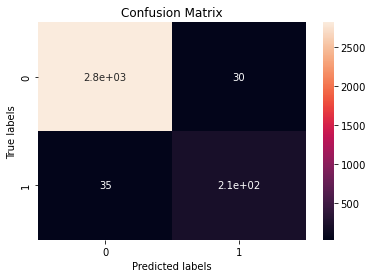

In [12]:
all_train_idx = np.array([
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
    ])
all_val_idx = (all_train_idx == 0).astype('int32')

totalRuns = 5
runNum = 1

for currRun in range(int(totalRuns)):
    foldNum = 0
    runSaveNum = int(runNum) + int(currRun)
    for train_index, val_index in zip(all_train_idx, all_val_idx):
        train_idx = train_index.nonzero()[0]
        val_idx = val_index.nonzero()[0]

        print(f'Fold: {foldNum}')

        # Select the current folds for training and validation
        noone_train = []
        nurse_train = []
        noone_val = []
        nurse_val = []
        for i in train_idx:
            noone_train += all_noone_list[i]
            nurse_train += all_nurse_list[i]
        for i in val_idx:
            noone_val += all_noone_list[i]
            nurse_val += all_nurse_list[i]

        # Move images to training and testing folders
        noone_train, nurse_train, noone_val, nurse_val = prepFiles(noone_train, nurse_train, noone_val, nurse_val)

        print(f"noone_train: {len(noone_train)}, nurse_train: {len(nurse_train)}")
        print(f"noone_val: {len(noone_val)}, nurse_val: {len(nurse_val)}\n")

        weight_for_0 = (1 / (len(noone_train) + len(noone_val))) * ((len(nurse_train) + len(nurse_val) + len(noone_train) + len(noone_val)) / 2.0)
        weight_for_1 = (1 / (len(nurse_train) + len(nurse_val))) * ((len(nurse_train) + len(nurse_val) + len(noone_train) + len(noone_val)) / 2.0)
        CLASS_WEIGHT = torch.tensor([weight_for_0, weight_for_1], device=device)

        # import data
        sets = ['train', 'val']
        image_datasets = {x: datasets.ImageFolder(os.path.join(ROOT_TRAIN_VAL_DATA_DIR, x), data_transforms[x]) for x in sets}
        dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True) for x in sets}
        dataset_sizes = {x: len(image_datasets[x]) for x in sets}

        class_names = image_datasets['train'].classes
        print(class_names)

        ###
        # train everything

        model = create_model(finetuning=FINETUNING)

        model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)


        model = train_model(model, dataloaders, dataset_sizes, criterion, optimizer, num_epochs=15)

        foldNum += 1

        modelPath = "savedModels/" + BASE_MODEL_NAME + "_run" + str(runSaveNum) + "_fold" + str(foldNum) + ".pth"
        torch.save(model.state_dict(), modelPath)

        evalModel(model, dataloaders['val'])